In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime
import math
import gc

from sklearn.metrics import roc_auc_score

import lightgbm as lgbm

import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data

In [6]:
stocks = ['ABIO',
 'AFKS',
 'AFLT',
 'ALRS',
 'APTK',
 'AQUA',
 'BANE',
 'BANEP',
 'BELU',
 'BSPB',
 'CBOM',
 'CHMF',
 'ENPG',
 'FEES',
 'FESH',
 'FLOT',
 'GAZP',
 'GMKN',
 'GTRK',
 'HEAD',
 'HYDR',
 'IRAO',
 'IRKT',
 'KMAZ',
 'LENT',
 'LIFE',
 'LKOH',
 'LSRG',
 'MAGN',
 'MDMG',
 'MGNT',
 'MOEX',
 'MTLR',
 'MTLRP',
 'MTSS',
 'MVID',
 'NLMK',
 'NMTP',
 'NVTK',
 'OGKB',
 'PHOR',
 'PIKK',
 'PLZL',
 'POSI',
 'RASP',
 'RENI',
 'RNFT',
 'ROSN',
 'RTKM',
 'RTKMP',
 'RUAL',
 'SBER',
 'SBERP',
 'SELG',
 'SFIN',
 'SGZH',
 'SIBN',
 'SMLT',
 'SNGS',
 'SNGSP',
 'SPBE',
 'SVAV',
 'T',
 'TATN',
 'TATNP',
 'TGKN',
 'TRMK',
 'TRNFP',
 'UNAC',
 'UPRO',
 'UWGN',
 'VKCO',
 'VSMO',
 'VTBR',
 'WUSH',
 'YDEX',


#'TMOS',
]

len(stocks)

76

In [10]:
df = load_pkl('./data/feat_engin/lgbm/data_1hour_1day.pkl')

In [12]:
df

,time,close,volume,ticker,tmos_close,index_1day,close_w5_alpha,close_w5_rsi,tmos_close_w5_alpha,tmos_close_w5_rsi,...,close_1day_w10_min/close_1day_w10_max,tmos_close_1day_w10_min/tmos_close_1day_w10_max,close_1day_w20_min/close_1day_w20_max,tmos_close_1day_w20_min/tmos_close_1day_w20_max,close_1day_w30_min/close_1day_w30_max,tmos_close_1day_w30_min/tmos_close_1day_w30_max,close_1day_w60_min/close_1day_w60_max,tmos_close_1day_w60_min/tmos_close_1day_w60_max,close_1day_w120_min/close_1day_w120_max,tmos_close_1day_w120_min/tmos_close_1day_w120_max
0,2022-12-21 09:00:00,60.36,63.0,ABIO,4.05,122.0,-9.985207,53.658537,134.615385,100.000000,...,0.919266,0.970588,0.909531,0.965854,0.892783,0.956522,0.724484,0.835749,0.577882,0.765101
1,2022-12-21 10:00:00,60.74,37821.0,ABIO,4.06,122.0,5.555556,57.777778,117.647059,100.000000,...,0.919266,0.970588,0.909531,0.965854,0.892783,0.956522,0.724484,0.835749,0.577882,0.765101
2,2022-12-21 11:00:00,60.60,11712.0,ABIO,4.06,122.0,5.842558,65.000000,117.647059,100.000000,...,0.919266,0.970588,0.909531,0.965854,0.892783,0.956522,0.724484,0.835749,0.577882,0.765101
3,2022-12-21 12:00:00,60.96,3129.0,ABIO,4.06,122.0,5.261738,74.074074,156.250000,100.000000,...,0.919266,0.970588,0.909531,0.965854,0.892783,0.956522,0.724484,0.835749,0.577882,0.765101
4,2022-12-21 13:00:00,60.80,4074.0,ABIO,4.06,122.0,5.379499,72.727273,250.000000,100.000000,...,0.919266,0.970588,0.909531,0.965854,0.892783,0.956522,0.724484,0.835749,0.577882,0.765101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588964,2025-02-24 19:00:00,4645.50,26140.0,YDEX,7.25,50953.0,0.045338,45.789474,78.947368,71.428571,...,0.895519,0.886921,0.837757,0.862398,0.837757,0.847411,0.681886,0.711172,0.681886,0.711172
588965,2025-02-24 20:00:00,4658.00,19307.0,YDEX,7.27,50953.0,0.070780,58.031088,72.222222,100.000000,...,0.895519,0.886921,0.837757,0.862398,0.837757,0.847411,0.681886,0.711172,0.681886,0.711172
588966,2025-02-24 21:00:00,4660.00,27796.0,YDEX,7.29,50953.0,0.083962,80.000000,58.219178,100.000000,...,0.895519,0.886921,0.837757,0.862398,0.837757,0.847411,0.681886,0.711172,0.681886,0.711172
588967,2025-02-24 22:00:00,4666.00,13530.0,YDEX,7.29,50953.0,0.116126,77.862595,67.307692,100.000000,...,0.895519,0.886921,0.837757,0.862398,0.837757,0.847411,0.681886,0.711172,0.681886,0.711172


## CHANGE TARGET

In [17]:
def get_target(df_all, ind, val_first, val_second, points_to_wait):
    #цель - достичь val_second, не достигнув val_first

    ind_end = min(ind+points_to_wait+1, df_all.shape[0])
    
    df = df_all.iloc[ind:ind_end].copy()
    
    mask_stock = np.array(df['ticker'] == df['ticker'].iloc[0])
    df = df.loc[mask_stock, :]

    start_price = df['close'].iloc[0]
    
    if val_first < val_second:                                 
        mask_val_first = np.array(df['close'] < val_first)
        mask_val_second = np.array(df['close'] > val_second)
    else: #short game
        mask_val_first = np.array(df['close'] > val_first)
        mask_val_second = np.array(df['close'] < val_second)

    
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() == 0):

        ind_end = df.shape[0]-1
        delta_time = df['time'].iloc[ind_end] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_end]
        if val_first < val_second:
            income_rate = res_price/start_price
        else: #short game
            income_rate = (2*start_price-res_price)/start_price
        return 'DNF', delta_time, income_rate, res_price, ind_end+ind
        
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() != 0):
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_second]
        if val_first < val_second:
            income_rate = res_price/start_price
        else: #short game
            income_rate = (2*start_price-res_price)/start_price
        return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind
        
    if (mask_val_first.sum() != 0) & (mask_val_second.sum() == 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_first]
        if val_first < val_second:
            income_rate = res_price/start_price
        else: #short game
            income_rate = (2*start_price-res_price)/start_price
        return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind

    if (mask_val_first.sum() != 0) & (mask_val_second.sum() != 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        if ind_val_first < ind_val_second:
            delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_first]
            if val_first < val_second:
                income_rate = res_price/start_price
            else: #short game
                income_rate = (2*start_price-res_price)/start_price
            return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind
        if ind_val_first > ind_val_second:
            delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_second]
            if val_first < val_second:
                income_rate = res_price/start_price
            else:  #short game
                income_rate = (2*start_price-res_price)/start_price
            return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind


def get_df_target(df, indx, percent_first=None, percent_second=None, points_to_wait=None):
    times = []
    results = []
    delta_times = []
    income_rates = []
    closes = []
    tickers = []
    res_prices = []
    res_inds = []
    
    #for ind in indx:
    for ind in tqdm(indx):
        time = df['time'].iloc[ind]
        close = df['close'].iloc[ind]
        ticker = df['ticker'].iloc[ind]
        
        val_first = df['close'].iloc[ind] * percent_first
        val_second = df['close'].iloc[ind] * percent_second
        result, delta_time, income_rate, res_price, res_ind = get_target(df, ind, val_first, val_second, points_to_wait)
        
        times += [time]
        closes += [close]
        tickers += [ticker]
        results += [result]
        delta_times += [delta_time]
        income_rates += [income_rate]
        res_prices += [res_price]
        res_inds += [res_ind]
        

    df_result = pd.DataFrame({'ind' : indx,
                              'time' : times,
                              'close' : closes,
                              'result' : results,
                              'ticker' : tickers, 
                              'delta_time' : delta_times,
                              'income_rate' : income_rates,
                              'res_price' : res_prices,
                              'res_ind' : res_inds
                             })

    #макс выигрыш и потери
    if percent_first < percent_second:  
        df_result["income_rate"] = np.maximum(df_result["income_rate"], percent_first) #макс потери
        df_result["income_rate"] = np.minimum(df_result["income_rate"], percent_second) #макс выигрыш
    else:
        df_result["income_rate"] = np.maximum(df_result["income_rate"], 2-percent_first) #макс потери
        df_result["income_rate"] = np.minimum(df_result["income_rate"], 2-percent_second) #макс выигрыш
    
    df_result['income_rate'] -= 0.001
    
    return df_result    

In [20]:
inds = np.arange(df.shape[0])
inds.shape

(588969,)

In [22]:
df_result = get_df_target(df[['time', 'close', 'ticker']], inds, percent_first=0.97, percent_second=1.06, points_to_wait=12*24*)

100%|███████████████████████████████████████████████████████████████| 588969/588969 [02:18<00:00, 4255.25it/s]


In [23]:
# dump_pkl(df_result, './data/feat_engin/lgbm/df_result_-2_+4_2day.pkl')

In [25]:
# df_result = load_pkl('./data/feat_engin/lgbm/df_result_-2_+4_2day.pkl')
# df_result

In [27]:
df_result['result'].value_counts(normalize=True)

result
DNF     0.540385
LOSE    0.322370
WIN     0.137245
Name: proportion, dtype: float64

In [28]:
df_result['income_rate'].quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00    0.979000
0.01    0.979000
0.10    0.979000
0.20    0.979000
0.30    0.979000
0.40    0.990426
0.50    0.997267
0.60    1.003291
0.70    1.010621
0.80    1.021440
0.90    1.039000
0.99    1.039000
1.00    1.039000
Name: income_rate, dtype: float64

In [31]:
#распределение времени в часах
(df_result['delta_time'] / pd.Timedelta('24 hours')).quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00     0.000000
0.01     0.083333
0.10     0.583333
0.20     1.000000
0.30     1.791667
0.40     2.000000
0.50     2.000000
0.60     2.041667
0.70     3.250000
0.80     4.000000
0.90     4.000000
0.99     5.041667
1.00    49.041667
Name: delta_time, dtype: float64

In [33]:
(df['close'].values == df_result['close'].values).all(), (df['time'].values == df_result['time'].values).all()

(True, True)

In [34]:
df[['ind', 'result', 'delta_time', 'income_rate', 'res_price', 'res_ind']] = df_result[['ind', 'result', 'delta_time', 'income_rate', 'res_price', 'res_ind']].values


/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_35846/157454442.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[['ind', 'result', 'delta_time', 'income_rate', 'res_price', 'res_ind']] = df_result[['ind', 'result', 'delta_time', 'income_rate', 'res_price', 'res_ind']].values
/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_35846/157454442.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[['ind', 'result', 'delta_time', 'income_rate', 'res_price', 'res_ind']] = df_result[['ind', 'result', 'delta_ti

In [35]:
df.head()

,time,close,volume,ticker,tmos_close,index_1day,close_w5_alpha,close_w5_rsi,tmos_close_w5_alpha,tmos_close_w5_rsi,...,close_1day_w60_min/close_1day_w60_max,tmos_close_1day_w60_min/tmos_close_1day_w60_max,close_1day_w120_min/close_1day_w120_max,tmos_close_1day_w120_min/tmos_close_1day_w120_max,ind,result,delta_time,income_rate,res_price,res_ind
0,2022-12-21 09:00:00,60.36,63.0,ABIO,4.05,122.0,-9.985207,53.658537,134.615385,100.0,...,0.724484,0.835749,0.577882,0.765101,0,DNF,5 days 00:00:00,1.03114,62.3,30
1,2022-12-21 10:00:00,60.74,37821.0,ABIO,4.06,122.0,5.555556,57.777778,117.647059,100.0,...,0.724484,0.835749,0.577882,0.765101,1,DNF,5 days 00:00:00,1.028635,62.54,31
2,2022-12-21 11:00:00,60.60,11712.0,ABIO,4.06,122.0,5.842558,65.000000,117.647059,100.0,...,0.724484,0.835749,0.577882,0.765101,2,WIN,5 days 00:00:00,1.039,63.06,32
3,2022-12-21 12:00:00,60.96,3129.0,ABIO,4.06,122.0,5.261738,74.074074,156.250000,100.0,...,0.724484,0.835749,0.577882,0.765101,3,WIN,5 days 00:00:00,1.039,63.92,33
4,2022-12-21 13:00:00,60.80,4074.0,ABIO,4.06,122.0,5.379499,72.727273,250.000000,100.0,...,0.724484,0.835749,0.577882,0.765101,4,WIN,4 days 23:00:00,1.039,63.92,33


In [36]:
assert (df.index == df['ind']).all(), 'Error'

In [38]:
#проверить данные

mask = df['time'] >= pd.Timestamp('2025-02-01')


i = 3730
cols = ['ticker', 'time', 'close', 'result', 'delta_time', 'income_rate', 'res_price', 'res_ind']
df.loc[mask, cols].iloc[i:i+10]

,ticker,time,close,result,delta_time,income_rate,res_price,res_ind
123979,FLOT,2025-02-18 19:00:00,102.51,LOSE,0 days 16:00:00,0.979,100.24,123986
123980,FLOT,2025-02-18 20:00:00,101.80,DNF,2 days 00:00:00,1.016485,103.58,124010
123981,FLOT,2025-02-18 21:00:00,101.31,DNF,2 days 00:00:00,1.023973,103.84,124011
123982,FLOT,2025-02-18 22:00:00,101.48,DNF,2 days 00:00:00,1.023832,104.0,124012
123983,FLOT,2025-02-18 23:00:00,101.89,DNF,2 days 00:00:00,1.020101,104.04,124013
123984,FLOT,2025-02-19 09:00:00,103.59,LOSE,0 days 02:00:00,0.979,100.24,123986
123985,FLOT,2025-02-19 10:00:00,103.20,LOSE,0 days 01:00:00,0.979,100.24,123986
123986,FLOT,2025-02-19 11:00:00,100.24,WIN,1 days 01:00:00,1.039,104.48,124002
123987,FLOT,2025-02-19 12:00:00,100.34,WIN,1 days 00:00:00,1.039,104.48,124002
123988,FLOT,2025-02-19 13:00:00,101.03,DNF,2 days 00:00:00,1.012164,102.36,124018


### 1. train/valid/test/test2 split

In [43]:
df['target'] = (df['result'] == 'WIN').astype(int)

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_35846/162261981.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['target'] = (df['result'] == 'WIN').astype(int)


<Axes: xlabel='time'>

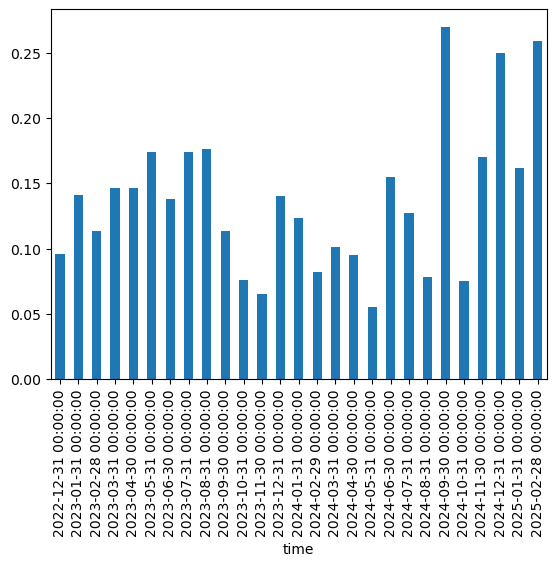

In [46]:
df.loc[:, ['time', 'target']].groupby(pd.Grouper(key='time', freq='ME')).target.mean().plot.bar()

<Axes: xlabel='time'>

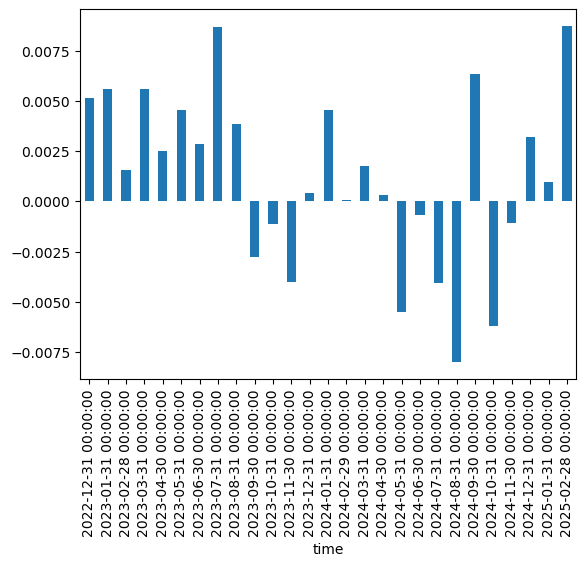

In [47]:
(df.loc[:, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq='ME')).income_rate.mean()-1).plot.bar()

In [49]:
pd.set_option('display.max_rows', 150)
df.loc[:, ['ticker', 'target']].groupby('ticker').target.mean().sort_values()

ticker
IRAO     0.038512
LKOH     0.044589
ROSN     0.048019
SBER     0.052214
SBERP    0.052569
PHOR     0.053273
MTSS     0.058434
TATNP    0.069203
HYDR     0.069321
MAGN     0.072975
TATN     0.073930
GMKN     0.075915
GAZP     0.079125
PLZL     0.085464
SIBN     0.086887
CBOM     0.088102
TRNFP    0.089301
ALRS     0.089662
NVTK     0.090349
RUAL     0.093909
SNGSP    0.094264
CHMF     0.095920
MGNT     0.096759
MOEX     0.098060
POSI     0.102382
VTBR     0.103699
RTKMP    0.104504
RTKM     0.106932
BELU     0.107205
T        0.111194
OGKB     0.111220
NLMK     0.113674
AQUA     0.117010
ENPG     0.117563
PIKK     0.120166
SNGS     0.120431
SMLT     0.122220
AFKS     0.133310
SGZH     0.133447
FEES     0.134775
YDEX     0.135724
UPRO     0.138032
VKCO     0.139457
VSMO     0.145338
MVID     0.145912
FLOT     0.146744
AFLT     0.147605
APTK     0.167539
MDMG     0.167834
LENT     0.168002
BSPB     0.170383
RASP     0.174375
BANEP    0.175695
SELG     0.176265
TRMK     0.177155
KMA

In [50]:
df.loc[:, ['ticker', 'income_rate']].groupby('ticker').income_rate.mean().sort_values()

ticker
HYDR     0.998665
VSMO     0.998761
SGZH      0.99918
SMLT     0.999213
LIFE     0.999532
RUAL     0.999555
IRKT     0.999582
PHOR     0.999623
APTK      0.99971
NVTK     0.999711
GMKN     0.999778
GAZP     0.999794
OGKB     0.999801
MAGN     0.999818
VTBR     0.999898
PIKK     0.999918
VKCO     1.000085
AQUA     1.000123
ENPG     1.000169
UNAC     1.000204
MTLRP    1.000225
RTKMP     1.00026
MVID     1.000325
ALRS     1.000344
WUSH     1.000379
ABIO     1.000431
TRMK      1.00044
TRNFP     1.00044
MTSS      1.00045
IRAO     1.000458
T        1.000519
KMAZ     1.000523
GTRK     1.000556
UWGN     1.000607
CBOM     1.000685
RTKM     1.000712
BELU     1.000726
FLOT     1.000727
SIBN     1.000773
SVAV     1.000774
ROSN     1.000849
MGNT     1.000851
SNGS      1.00087
POSI     1.001006
LENT     1.001047
FESH     1.001053
FEES     1.001119
SELG     1.001153
RASP     1.001298
MTLR     1.001313
AFKS      1.00137
NLMK      1.00143
CHMF     1.001521
SPBE     1.001618
LKOH      1.00162
UPR

In [53]:
df['time'].max()

Timestamp('2025-02-24 23:00:00')

In [54]:
mask_train = np.array(df['time'] < pd.Timestamp('2024-07-01'))
mask_valid = np.array((pd.Timestamp('2024-07-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-09-01')))
mask_test = np.array((pd.Timestamp('2024-09-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-11-01')))
mask_test2 = np.array((pd.Timestamp('2024-11-01') <= df['time']) & (df['time'] < pd.Timestamp('2025-01-01')))
mask_test3 = np.array(pd.Timestamp('2025-01-01') <= df['time'])

In [55]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(397071, 50237, 49861, 48761)

In [56]:
mask_test3.sum()

43039

In [58]:
mask_data = mask_train|mask_valid|mask_test|mask_test2
(mask_data).sum()

545930

In [60]:
mask_train.sum()/(mask_data).sum(), mask_valid.sum()/(mask_data).sum(), mask_test.sum()/(mask_data).sum(), mask_test2.sum()/(mask_data).sum()

(0.7273295111094829,
 0.0920209550674995,
 0.09133222207975382,
 0.0893173117432638)

In [62]:
df.loc[mask_train, 'target'].mean(), df.loc[mask_valid, 'target'].mean(), df.loc[mask_test, 'target'].mean(), df.loc[mask_test2, 'target'].mean()

(0.12173893333937759,
 0.10307144136791607,
 0.16724494093580153,
 0.21078320789155267)

In [63]:
df.loc[mask_test3, 'target'].mean()

0.20211900834127186

In [65]:
df.loc[mask_train, 'income_rate'].mean(), df.loc[mask_valid, 'income_rate'].mean(), df.loc[mask_test, 'income_rate'].mean(), df.loc[mask_test2, 'income_rate'].mean()

(1.001549401721077, 0.993971826669329, 0.9997447322462749, 1.0011150426967896)

In [66]:
df.loc[mask_test3, 'income_rate'].mean()

1.0042355922501918

In [68]:
df.loc[mask_test3, ['ticker', 'income_rate']].groupby('ticker').income_rate.mean().sort_values()

ticker
SNGSP    0.997658
ROSN     0.997975
MAGN     0.998181
UNAC     0.998726
CBOM     0.999052
TRNFP    0.999128
SIBN     0.999724
POSI     0.999951
BANEP    1.000367
HEAD     1.000614
FLOT     1.000829
IRAO     1.001843
LKOH      1.00187
TATNP    1.001871
UWGN     1.002076
MGNT     1.002154
AFLT     1.002379
APTK     1.002399
BSPB     1.002537
LIFE     1.002542
FEES     1.002703
MTLRP    1.003049
LSRG     1.003159
RASP     1.003499
HYDR     1.003523
VKCO     1.003595
RTKM     1.003629
ABIO     1.003629
SBERP    1.003676
PHOR     1.003693
MOEX     1.003907
SNGS     1.004002
OGKB     1.004044
AFKS     1.004057
NLMK      1.00414
SBER     1.004185
BANE      1.00427
FESH      1.00429
SGZH     1.004479
LENT     1.004505
VTBR     1.004589
IRKT     1.004608
SELG     1.004638
SFIN     1.004647
PIKK     1.004654
TATN     1.004805
MVID     1.004809
RNFT     1.004894
NMTP     1.004942
ALRS     1.004952
RENI     1.004952
SVAV     1.005011
MDMG     1.005109
BELU     1.005193
WUSH     1.005239
MTL

In [71]:
#проверки

In [72]:
(mask_train.sum()+mask_valid.sum()+mask_test.sum()+mask_test2.sum()) ==(mask_data).sum()

#(mask_train.sum()+mask_valid.sum()+mask_test.sum()) ==(mask_data).sum()

True

## 3. Model

### 3.1 Base model

In [76]:
df['ticker_code'] = df['ticker'].astype('category').cat.codes

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_35846/153766446.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ticker_code'] = df['ticker'].astype('category').cat.codes


In [77]:
df['ticker_code'].nunique()

76

In [78]:
df.loc[mask_train, 'ticker_code'].nunique()

76

In [80]:
drop_cols = [
 'time',
 'close',
 'volume',
 'tmos_close',
 'ticker',

 'index_1day',
 'date_day_index',
    
 'time_1day',
 'close_1day',
 'volume_1day',
 'tmos_close_1day',

 'ind',
 'result',
 'delta_time',
 'income_rate',
 'res_price',
 'res_ind',


    'target', 
    'y_pred'
]




features_all = df.columns[~df.columns.isin(drop_cols)].tolist()

cat_features_all = ['ticker_code',
                'hour', 'day', 'weekday',
]
cat_features = cat_features_all

target = 'target'

In [81]:
len(features_all), len(cat_features)

(428, 4)

In [82]:
features_all

['close_w5_alpha',
 'close_w5_rsi',
 'tmos_close_w5_alpha',
 'tmos_close_w5_rsi',
 'close_w10_alpha',
 'close_w10_rsi',
 'tmos_close_w10_alpha',
 'tmos_close_w10_rsi',
 'close_w20_alpha',
 'close_w20_rsi',
 'tmos_close_w20_alpha',
 'tmos_close_w20_rsi',
 'close_w30_alpha',
 'close_w30_rsi',
 'tmos_close_w30_alpha',
 'tmos_close_w30_rsi',
 'close_w30_lvl_1-1.03',
 'close_w30_lvl_-0.97-1',
 'close_w30_lvl_1.03-1.05',
 'close_w30_lvl_-0.95-0.97',
 'close_w30_lvl_1.05-1.07',
 'close_w30_lvl_-0.9299999999999999-0.95',
 'close_w30_lvl_1.07-1.1',
 'close_w30_lvl_-0.9-0.9299999999999999',
 'tmos_close_w30_lvl_1-1.03',
 'tmos_close_w30_lvl_-0.97-1',
 'tmos_close_w30_lvl_1.03-1.05',
 'tmos_close_w30_lvl_-0.95-0.97',
 'tmos_close_w30_lvl_1.05-1.07',
 'tmos_close_w30_lvl_-0.9299999999999999-0.95',
 'tmos_close_w30_lvl_1.07-1.1',
 'tmos_close_w30_lvl_-0.9-0.9299999999999999',
 'close_w60_alpha',
 'close_w60_rsi',
 'tmos_close_w60_alpha',
 'tmos_close_w60_rsi',
 'close_w120_alpha',
 'close_w120_rsi'

### 1. PSI

In [84]:
def psi(expected: np.ndarray, actual: np.ndarray, bucket_type: str = "bins", n_bins: int = 10) -> float:
    """Calculate PSI metric for two arrays.
    
    Parameters
    ----------
        expected : list-like
            Array of expected values
        actual : list-like
            Array of actual values
        bucket_type : str
            Binning strategy. Accepts two options: 'bins' and 'quantiles'. Defaults to 'bins'.
            'bins': input arrays are splitted into bins with equal
                and fixed steps based on 'expected' array
            'quantiles': input arrays are binned according to 'expected' array
                with given number of n_bins
        n_bins : int
            Number of buckets for binning. Defaults to 10.

    Returns
    -------
        A single float number
    """
    breakpoints = np.arange(0, n_bins + 1) / (n_bins) * 100
    if bucket_type == "bins":
        breakpoints = np.histogram(expected, n_bins)[1]
    elif bucket_type == "quantiles":
        breakpoints = np.percentile(expected, breakpoints)

    # Calculate frequencies
    expected_percents = np.histogram(expected, breakpoints)[0] / len(expected)
    actual_percents = np.histogram(actual, breakpoints)[0] / len(actual)
    # Clip freaquencies to avoid zero division
    expected_percents = np.clip(expected_percents, a_min=0.0001, a_max=None)
    actual_percents = np.clip(actual_percents, a_min=0.0001, a_max=None)
    # Calculate PSI
    psi_value = (expected_percents - actual_percents) * np.log(expected_percents / actual_percents)
    psi_value = sum(psi_value)

    return psi_value

In [87]:
psi_features = {'feature' : [],
                
               'psi_valid' : [],
               'psi_test' : [],
               'psi_test2' : [],

               'psi_neg_valid' : [],
               'psi_neg_test' : [],
               'psi_neg_test2' : [],

               'psi_pos_valid' : [],
               'psi_pos_test' : [],
               'psi_pos_test2' : [],
               }

for feature in tqdm(features_all):

    mask_pos = df['target'] == 1
    mask_neg = ~mask_pos

    psi_features['feature'] += [feature]
    
    psi_features['psi_valid'] += [psi(df.loc[mask_train, feature].values, df.loc[mask_valid, feature].values)]
    psi_features['psi_test'] += [psi(df.loc[mask_train, feature].values, df.loc[mask_test, feature].values)]
    psi_features['psi_test2'] += [psi(df.loc[mask_train, feature].values, df.loc[mask_test2, feature].values)]

    psi_features['psi_neg_valid'] += [psi(df.loc[mask_train&mask_neg, feature].values, df.loc[mask_valid&mask_neg, feature].values)]
    psi_features['psi_neg_test'] += [psi(df.loc[mask_train&mask_neg, feature].values, df.loc[mask_test&mask_neg, feature].values)]
    psi_features['psi_neg_test2'] += [psi(df.loc[mask_train&mask_neg, feature].values, df.loc[mask_test2&mask_neg, feature].values)]

    psi_features['psi_pos_valid'] += [psi(df.loc[mask_train&mask_pos, feature].values, df.loc[mask_valid&mask_pos, feature].values)]
    psi_features['psi_pos_test'] += [psi(df.loc[mask_train&mask_pos, feature].values, df.loc[mask_test&mask_pos, feature].values)]
    psi_features['psi_pos_test2'] += [psi(df.loc[mask_train&mask_pos, feature].values, df.loc[mask_test2&mask_pos, feature].values)]

df_psi = pd.DataFrame(psi_features)

100%|███████████████████████████████████████████████████████████████████████| 428/428 [00:37<00:00, 11.53it/s]


In [88]:
df_psi.head()

,feature,psi_valid,psi_test,psi_test2,psi_neg_valid,psi_neg_test,psi_neg_test2,psi_pos_valid,psi_pos_test,psi_pos_test2
0,close_w5_alpha,0.014284,0.000634,0.000315,0.012923,0.000594,0.001052,0.028661,0.009268,0.003096
1,close_w5_rsi,0.032545,0.006589,0.006400,0.029642,0.007939,0.009138,0.064533,0.011956,0.001868
2,tmos_close_w5_alpha,0.308262,0.324149,0.443540,0.298346,0.332578,0.437596,0.443806,0.325685,0.506150
3,tmos_close_w5_rsi,0.288749,0.253127,0.103716,0.275465,0.271087,0.110664,0.440692,0.191217,0.157533
4,close_w10_alpha,0.001290,0.001308,0.001205,0.000968,0.001110,0.000623,0.005157,0.008034,0.008927


In [89]:
df_psi[df_psi['feature'] == 'day'] 

,feature,psi_valid,psi_test,psi_test2,psi_neg_valid,psi_neg_test,psi_neg_test2,psi_pos_valid,psi_pos_test,psi_pos_test2
57,day,0.021678,0.059558,0.059026,0.031913,0.096304,0.059829,0.622653,0.193994,0.703557


In [92]:
psi_threshold = 0.1
mask_psi_pos_neg = (df_psi['psi_valid'] < psi_threshold) & (df_psi['psi_test'] < psi_threshold) & (df_psi['psi_test2'] < psi_threshold)
mask_psi_neg = (df_psi['psi_neg_valid'] < psi_threshold) & (df_psi['psi_neg_test'] < psi_threshold) & (df_psi['psi_neg_test2'] < psi_threshold)
mask_psi_pos = (df_psi['psi_pos_valid'] < psi_threshold) & (df_psi['psi_pos_test'] < psi_threshold) & (df_psi['psi_pos_test2'] < psi_threshold)


In [93]:
len(features_all)

428

In [94]:
mask_psi_pos_neg.sum(), (mask_psi_pos_neg & mask_psi_neg & mask_psi_pos).sum()

(134, 104)

In [95]:
mask_psi = mask_psi_pos_neg# & mask_psi_neg & mask_psi_pos

In [96]:
np.array(features_all)[mask_psi]

array(['close_w5_alpha', 'close_w5_rsi', 'close_w10_alpha',
       'close_w10_rsi', 'close_w20_alpha', 'close_w30_alpha',
       'close_w30_lvl_1-1.03', 'close_w30_lvl_-0.97-1',
       'close_w30_lvl_-0.95-0.97', 'close_w30_lvl_1.05-1.07',
       'close_w30_lvl_-0.9299999999999999-0.95', 'close_w30_lvl_1.07-1.1',
       'close_w30_lvl_-0.9-0.9299999999999999',
       'tmos_close_w30_lvl_1.07-1.1',
       'tmos_close_w30_lvl_-0.9-0.9299999999999999', 'close_w60_alpha',
       'close_w120_alpha', 'close_w120_lvl_-0.95-0.97',
       'close_w120_lvl_-0.9299999999999999-0.95',
       'close_w120_lvl_-0.9-0.9299999999999999', 'hour', 'day', 'weekday',
       'close_1day_w5_alpha', 'close_1day_w10_alpha',
       'close_1day_w20_alpha', 'close_1day_w30_alpha',
       'close_1day_w60_alpha', 'close_1day_w120_alpha',
       'close_1day_w120_lvl_1.05-1.07', 'close_w5_alpha/close_w10_alpha',
       'close_w5_alpha/close_w20_alpha', 'close_w5_alpha/close_w30_alpha',
       'close_w5_alpha/close_w60

In [97]:
features_psi = np.array(features_all)[mask_psi]
len(features_psi)

134

### 2. Correlation

In [162]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(397071, 50237, 49861, 48761)

In [165]:
features = features_psi.copy()
len(features)

76

In [204]:
mask_corr = np.ones_like(features).astype(bool)
#mask_corr

In [206]:
corr_threshold = 0.99

for i in tqdm(range(len(features) - 1)):
    if mask_corr[i]:
        for j in range(i+1, len(features)):
            if mask_corr[j]:        
                corr = abs(np.corrcoef(df.loc[mask_train, features[i]], df.loc[mask_train, features[j]])[0,1])
                if corr > corr_threshold:
                    mask_corr[j] = False
mask_corr.sum()

  0%|                                                                                  | 0/72 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|█████████████████████████████████████████████████████████████████████████| 72/72 [00:08<00:00,  8.81it/s]


73

In [208]:
np.array(features)[~mask_corr]

array([], dtype='<U52')

In [211]:
features_corr = np.array(features)[mask_corr]
len(features_corr)

73

In [213]:
features_corr

array(['close_w5_rsi', 'close_w10_rsi', 'close_w30_lvl_1-1.03',
       'close_w30_lvl_-0.97-1', 'close_w30_lvl_1.03-1.05',
       'close_w30_lvl_-0.95-0.97', 'close_w30_lvl_1.05-1.07',
       'close_w30_lvl_-0.9299999999999999-0.95',
       'close_w30_lvl_-0.9-0.9299999999999999',
       'tmos_close_w30_lvl_-0.9299999999999999-0.95',
       'tmos_close_w30_lvl_1.07-1.1',
       'tmos_close_w30_lvl_-0.9-0.9299999999999999',
       'close_w120_lvl_1-1.03', 'close_w120_lvl_-0.95-0.97',
       'close_w120_lvl_-0.9299999999999999-0.95',
       'close_w120_lvl_-0.9-0.9299999999999999', 'hour', 'weekday',
       'close_1day_w30_lvl_1-1.03', 'close/close_w5_expma',
       'close/close_w10_expma', 'close/close_w20_expma',
       'close/close_w30_expma', 'close_w5_expma/close_w10_expma',
       'close_w5_expma/close_w20_expma', 'close_w5_expma/close_w30_expma',
       'close_w5_expma/close_w60_expma',
       'close_w10_expma/close_w20_expma',
       'close_w20_expma/close_w30_expma', 'close_w5_m

#### 2. Useful features

In [216]:
# def get_useful_features(feature):
#     for elem in ['volume', 'std', 'pct', 'alpha', 'rsi/', 'roc', 'ticker_code', 'hour', '_ma']:
#         if elem in feature:
#             return False
#     return True

# mask_useful_features = np.array([get_useful_features(feature) for feature in features_psi])
# features_useful = np.array(features_psi)[mask_useful_features].tolist()
# len(features_useful), features_useful


### 3. Get stability features

In [241]:


def mean_win_rate_point(D_sample, y_pred, threshold=None):
    #mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    score = np.mean(D_sample.label[mask])
    
    return score




def mean_income_rate_point(D_sample, y_pred, threshold=None):
    #mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    score = np.mean(D_sample.income_rate[mask]) - 1
    
    return score

def mean_income_rate_tick(D_sample, y_pred, threshold=None):
    #mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup[mask].groupby('time').income_rate.mean()-1).mean()
    
    return score



def mean_income_rate_day(D_sample, y_pred, threshold=None):
    # threshold=threshold
    #mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup[mask].groupby('time').income_rate.mean()-1).reset_index().groupby(pd.Grouper(key='time', freq='D')).income_rate.mean().mean()

    return score
    
def mean_income_rate_month(D_sample, y_pred, threshold=None):
    #mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup[mask].groupby('time').income_rate.mean()-1).reset_index().groupby(pd.Grouper(key='time', freq='D')).income_rate.mean().mean() * df_sup.loc[mask, 'time'].dt.date.nunique() 
    score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month
    
    return score


def mean_income_rate(y_pred, D_sample):
    q = 0.995
    mask = y_pred >= np.quantile(y_pred, q)
    #mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    # month
    # score = (df_sup[mask].groupby('time').income_rate.mean()-1).reset_index().groupby(pd.Grouper(key='time', frethreshold='D')).income_rate.mean().mean() * df_sup.loc[mask, 'time'].dt.date.nunique() 
    # score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month

    # tick
    score = (df_sup[mask].groupby('time').income_rate.mean()-1).mean()
    
    # point
    # score = np.mean(D_sample.income_rate[mask]) - 1

    #point win_rate
    # score = np.mean(D_sample.label[mask])

    score = round(score, 5)
    return 'mean_income_rate', score, True#is_higher_better





In [243]:
features = features_psi.copy()
len(features)

134

In [245]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    
    "num_leaves": 2,

     "bagging_fraction": 0.7,
     "bagging_freq": 1,
     "verbose": -1,
     #"metric": "auc",
    "metric": "mean_income_rate",   
    "early_stopping" : 10, 
    
    
}

auc_features = {'feature' : [],
                
               'auc_train' : [],
               'auc_valid' : [],
               'auc_test' : [],
               'auc_test2' : [],
           
           'mir_point@1_train' : [],
           'mir_point@1_valid' : [],
           'mir_point@1_test' : [],
           'mir_point@1_test2' : [],

           'mir_tick@1_train' : [],
           'mir_tick@1_valid' : [],
           'mir_tick@1_test' : [],
           'mir_tick@1_test2' : [],


           'mir_day@1_train' : [],
           'mir_day@1_valid' : [],
           'mir_day@1_test' : [],
           'mir_day@1_test2' : [],

           'mir_month@1_train' : [],
           'mir_month@1_valid' : [],
           'mir_month@1_test' : [],
           'mir_month@1_test2' : [],

           'mean_win_rate_point@1_train' : [],
           'mean_win_rate_point@1_valid' : [],
           'mean_win_rate_point@1_test' : [],
           'mean_win_rate_point@1_test2' : [],

        
               }

for feature in tqdm(features):
    stab_features = [feature]
    stab_cat_features = [feature] if feature in cat_features else []
    
    D_train = lgbm.Dataset(df.loc[mask_train, stab_features], label=df.loc[mask_train, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
    D_valid = lgbm.Dataset(df.loc[mask_valid, stab_features], label=df.loc[mask_valid, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
    D_test = lgbm.Dataset(df.loc[mask_test, stab_features], label=df.loc[mask_test, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
    D_test2 = lgbm.Dataset(df.loc[mask_test2, stab_features], label=df.loc[mask_test2, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)

    D_train.income_rate = df.loc[mask_train, 'income_rate'].values
    D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
    D_test.income_rate = df.loc[mask_test, 'income_rate'].values
    D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values
    
    D_train.time = df.loc[mask_train, 'time'].values
    D_valid.time = df.loc[mask_valid, 'time'].values
    D_test.time = df.loc[mask_test, 'time'].values
    D_test2.time = df.loc[mask_test2, 'time'].values


    
    model = lgbm.train(params, num_boost_round=1000, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate)
    
    y_pred_train = model.predict(D_train.data)
    y_pred_valid = model.predict(D_valid.data)
    y_pred_test = model.predict(D_test.data)
    y_pred_test2 = model.predict(D_test2.data)

    auc_features['feature'] += [feature]
    auc_features['auc_train'] += [roc_auc_score(D_train.label, y_pred_train)]
    auc_features['auc_valid'] += [roc_auc_score(D_valid.label, y_pred_valid)]
    auc_features['auc_test'] += [roc_auc_score(D_test.label, y_pred_test)]
    auc_features['auc_test2'] += [roc_auc_score(D_test2.label, y_pred_test2)]

    
    threshold = np.quantile(y_pred_valid, q=0.995) #в feval тоже нужно менять
    
    auc_features['mir_point@1_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold)]
    auc_features['mir_point@1_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold)]
    auc_features['mir_point@1_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold)]
    auc_features['mir_point@1_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold)]

    auc_features['mir_tick@1_train'] += [mean_income_rate_tick(D_train, y_pred_train, threshold=threshold)]
    auc_features['mir_tick@1_valid'] += [mean_income_rate_tick(D_valid, y_pred_valid, threshold=threshold)]
    auc_features['mir_tick@1_test'] += [mean_income_rate_tick(D_test, y_pred_test, threshold=threshold)]
    auc_features['mir_tick@1_test2'] += [mean_income_rate_tick(D_test2, y_pred_test2, threshold=threshold)]

    auc_features['mir_day@1_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold)]
    auc_features['mir_day@1_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold)]
    auc_features['mir_day@1_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold)]
    auc_features['mir_day@1_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold)]

    
    auc_features['mir_month@1_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold)]
    auc_features['mir_month@1_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold)]
    auc_features['mir_month@1_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold)]
    auc_features['mir_month@1_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)]

    auc_features['mean_win_rate_point@1_train'] += [mean_win_rate_point(D_train, y_pred_train, threshold=threshold)]
    auc_features['mean_win_rate_point@1_valid'] += [mean_win_rate_point(D_valid, y_pred_valid, threshold=threshold)]
    auc_features['mean_win_rate_point@1_test'] += [mean_win_rate_point(D_test, y_pred_test, threshold=threshold)]
    auc_features['mean_win_rate_point@1_test2'] += [mean_win_rate_point(D_test2, y_pred_test2, threshold=threshold)]

df_auc = pd.DataFrame(auc_features)

 19%|█████████████▍                                                          | 25/134 [00:14<00:45,  2.40it/s]/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:131: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount
 19%|█████████████▉                                                          | 26/134 [00:14<00:42,  2.53it/s]/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:131: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount
100%|███████████████████████████████████████████████████████████████████████| 134/134 [01:30<00:00,  1.47it/s]


In [248]:
pd.set_option('display.max_columns', 100)
df_auc = pd.DataFrame(auc_features)
df_auc

,feature,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_tick@1_train,mir_tick@1_valid,mir_tick@1_test,mir_tick@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mean_win_rate_point@1_train,mean_win_rate_point@1_valid,mean_win_rate_point@1_test,mean_win_rate_point@1_test2
0,close_w5_alpha,0.506037,0.505608,0.501686,0.500507,0.004628,-0.000785,-0.001807,-0.001174,0.004548,-0.001028,-0.001066,-1.453449e-03,0.003492,-0.001497,-0.000842,-1.231316e-03,0.072376,-0.032927,-0.018518,-0.027089,0.287516,0.208502,0.207972,0.224872
1,close_w5_rsi,0.521002,0.502304,0.502448,0.521214,0.002380,-0.005154,-0.000403,0.004149,0.001647,-0.006815,-0.001195,3.110540e-04,0.001166,-0.007206,-0.001554,-8.423920e-04,0.025654,-0.158533,-0.034185,-0.018533,0.140645,0.105479,0.167591,0.233360
2,close_w10_alpha,0.503766,0.502981,0.502425,0.501095,0.006591,0.000357,0.001578,0.001684,0.007032,0.000139,0.001913,1.379474e-03,0.004752,-0.003273,-0.002549,-1.657184e-03,0.070135,-0.057598,-0.049710,-0.033067,0.328590,0.207547,0.288809,0.274021
3,close_w10_rsi,0.521694,0.495943,0.496252,0.519312,0.002792,-0.005805,-0.000844,0.005515,0.002478,-0.006471,-0.000487,1.442645e-03,0.001879,-0.007710,-0.000326,-7.042412e-04,0.041330,-0.169610,-0.007172,-0.015493,0.151920,0.096562,0.159811,0.250766
4,close_w20_alpha,0.504865,0.502033,0.501281,0.500888,0.004858,-0.000775,-0.003120,0.003419,0.005151,-0.000801,-0.002544,3.418831e-03,0.004362,-0.002705,-0.005883,-3.211290e-04,0.053290,-0.039681,-0.082363,-0.004929,0.311526,0.195312,0.233463,0.261364
5,close_w30_alpha,0.504132,0.501595,0.501417,0.501361,0.005930,-0.002619,-0.002602,0.003588,0.006083,-0.002630,-0.002455,3.587779e-03,0.005891,-0.003449,-0.002489,2.468836e-03,0.065456,-0.043835,-0.034845,0.032841,0.341693,0.161417,0.245059,0.287197
6,close_w30_lvl_1-1.03,0.571147,0.589148,0.553728,0.575470,0.002267,-0.005037,-0.000930,0.004531,0.002156,-0.005428,-0.001653,2.968207e-04,0.002064,-0.005478,-0.001756,2.202998e-04,0.045405,-0.120509,-0.038627,0.004847,0.152214,0.122864,0.168238,0.258633
7,close_w30_lvl_-0.97-1,0.513083,0.510536,0.503379,0.452422,0.000933,-0.006751,-0.000168,-0.001477,0.001311,-0.006014,-0.000284,-4.822442e-08,0.001416,-0.006014,-0.000284,-4.822442e-08,0.031148,-0.132307,-0.006247,-0.000001,0.127779,0.106466,0.169026,0.180743
8,close_w30_lvl_-0.95-0.97,0.556321,0.530833,0.541002,0.537983,0.000979,-0.005983,0.000821,0.003883,0.001279,-0.004606,0.000921,1.009608e-03,0.001250,-0.005169,0.000763,-9.563123e-05,0.027509,-0.113725,0.016794,-0.002104,0.189200,0.132780,0.216349,0.250812
9,close_w30_lvl_1.05-1.07,0.529775,0.583038,0.547903,0.500311,0.000555,-0.000877,0.003601,-0.002366,-0.001351,-0.005225,-0.001929,-1.550548e-03,-0.000704,-0.002264,-0.001493,1.604643e-03,-0.014780,-0.048702,-0.031350,0.033660,0.228725,0.218675,0.281875,0.211655


#### auc <=0.525

In [254]:
auc_treshold = 0.5

In [256]:
mask_auc_train  = df_auc['auc_train'] <= auc_treshold 
mask_auc_train.sum()

1

In [258]:
mask_auc_valid  = df_auc['auc_valid'] <= auc_treshold 
mask_auc_valid.sum()

15

In [260]:
mask_auc_test  = df_auc['auc_test'] <= auc_treshold 
mask_auc_test.sum()

22

In [262]:
(mask_auc_train | mask_auc_valid | mask_auc_test).sum()

29

In [422]:
mask_auc_test2  = df_auc['auc_test2'] <= auc_treshold 
mask_auc_test2.sum()

9

In [424]:
(mask_auc_train | mask_auc_valid | mask_auc_test | mask_auc_test2).sum()

9

#### delta_auc > 0.05

In [428]:
auc_delta_treshold  = 0.025

In [430]:
mask_auc_delta_valid = (df_auc['auc_train'] - df_auc['auc_valid']).abs() > auc_delta_treshold
mask_auc_delta_valid.sum()

17

In [432]:
mask_auc_delta_test = (df_auc['auc_train'] - df_auc['auc_test']).abs() > auc_delta_treshold
mask_auc_delta_test.sum()

15

In [434]:
(mask_auc_delta_valid | mask_auc_delta_test).sum()

24

In [437]:
mask_auc_delta_test2 = (df_auc['auc_train'] - df_auc['auc_test2']).abs() > auc_delta_treshold
mask_auc_delta_test2.sum()

39

In [439]:
(mask_auc_delta_valid | mask_auc_delta_test | mask_auc_delta_test2).sum()

43

#### union criterias

In [856]:
mask_criterias1 = mask_auc_train | mask_auc_valid | mask_auc_test | mask_auc_delta_valid | mask_auc_delta_test
mask_criterias1.sum()

25

In [858]:
mask_criterias2 = mask_auc_train | mask_auc_valid | mask_auc_test | mask_auc_test2 | mask_auc_delta_valid | mask_auc_delta_test | mask_auc_delta_test2
mask_criterias2.sum()

45

In [448]:
features_criteria1 = df_auc['feature'].values[~mask_criterias1]
len(features_criteria1), features_criteria1

(23,
 array(['close_w5_rsi', 'close_w30_lvl_1-1.03', 'close_w30_lvl_-0.97-1',
        'close_w30_lvl_-0.9299999999999999-0.95',
        'close_w30_lvl_-0.9-0.9299999999999999',
        'tmos_close_w30_lvl_1.07-1.1', 'close_w5_min/close',
        'close_w5_max/close', 'close_w10_max/close',
        'close_w5_expma_low_2std/close', 'close_w5_expma_up_2std/close',
        'close_w5_expma_low_3std/close', 'close_w5_expma_up_3std/close',
        'close_w10_expma_low_2std/close', 'close_w10_expma_up_2std/close',
        'close_w10_expma_low_3std/close', 'close_w10_expma_up_3std/close',
        'close_w20_expma_low_2std/close', 'close_w20_expma_low_3std/close',
        'close_w20_expma_up_3std/close', 'close_w5_min/close_w5_max',
        'close_w10_min/close_w10_max', 'close_w20_min/close_w20_max'],
       dtype=object))

In [851]:
df_auc.loc[df_auc['feature'].isin(features_criteria1)].sort_values('auc_valid', ascending=False)

,feature,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_tick@1_train,mir_tick@1_valid,mir_tick@1_test,mir_tick@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mean_win_rate_point@1_train,mean_win_rate_point@1_valid,mean_win_rate_point@1_test,mean_win_rate_point@1_test2
207,close_w10_min/close_w10_max,0.551754,0.625089,0.601310,0.503421,0.003840,-0.004142,0.003461,0.007539,0.003202,-0.004795,-0.001396,-0.000308,0.003046,-0.005099,-0.002874,-0.002217,0.061447,-0.097225,-0.061800,-0.046512,0.338893,0.235885,0.340228,0.398223
209,close_w20_min/close_w20_max,0.551706,0.621256,0.590848,0.491671,0.002465,-0.003538,0.004655,0.002990,0.002432,-0.004164,-0.001941,-0.001394,0.002820,-0.004845,-0.002182,-0.002504,0.060955,-0.099483,-0.048002,-0.055079,0.313890,0.240543,0.349301,0.333820
167,close_w10_expma_low_3std/close,0.550514,0.617106,0.590905,0.518397,0.003991,-0.006075,0.004027,0.004885,0.003066,-0.006313,-0.001771,0.000419,0.003078,-0.007323,-0.002561,-0.001727,0.067372,-0.161113,-0.056350,-0.037998,0.318185,0.197972,0.336831,0.356628
205,close_w5_min/close_w5_max,0.546222,0.612289,0.584434,0.509943,0.003211,-0.004049,0.002508,0.005906,0.002702,-0.004597,-0.001522,-0.000952,0.003273,-0.005328,-0.002783,-0.003259,0.070736,-0.117225,-0.061215,-0.071694,0.325377,0.229383,0.320238,0.374621
159,close_w5_expma_low_3std/close,0.546599,0.610586,0.581410,0.517954,0.003704,-0.006160,0.000300,0.008059,0.003183,-0.006434,-0.004386,0.001215,0.002754,-0.008514,-0.005271,-0.002922,0.058006,-0.178975,-0.113318,-0.055308,0.334698,0.200205,0.293886,0.401864
160,close_w5_expma_up_3std/close,0.540952,0.601907,0.577748,0.501523,0.003190,-0.002225,0.001374,0.008402,0.002019,-0.001626,-0.002537,0.000447,0.004407,0.001498,-0.003620,0.002413,0.089654,0.030025,-0.079640,0.048139,0.327887,0.255687,0.302995,0.412600
168,close_w10_expma_up_3std/close,0.537196,0.600938,0.578396,0.485417,0.003955,-0.001816,0.003271,0.007403,0.001758,-0.003925,-0.002068,0.001410,0.003377,-0.002037,-0.001982,0.003488,0.058428,-0.032867,-0.040637,0.055323,0.343856,0.273026,0.334324,0.398115
175,close_w20_expma_low_3std/close,0.549180,0.600357,0.578267,0.519157,0.002847,-0.007289,0.002953,0.003990,0.002390,-0.005355,-0.001783,-0.000938,0.001951,-0.006148,-0.003294,-0.003791,0.041623,-0.123234,-0.072463,-0.079529,0.317179,0.190518,0.317315,0.345315
165,close_w10_expma_low_2std/close,0.546605,0.599623,0.578885,0.528726,0.005738,-0.006302,0.000556,0.009281,0.004680,-0.005023,-0.001643,-0.001208,0.002173,-0.005869,-0.006184,-0.005009,0.042639,-0.097563,-0.117498,-0.087131,0.366305,0.200632,0.299342,0.423202
176,close_w20_expma_up_3std/close,0.529632,0.597578,0.575775,0.460131,0.003946,0.003593,0.004886,0.006480,0.000787,0.001397,-0.007351,0.003592,0.004084,0.000976,-0.001951,0.007817,0.053276,0.012411,-0.026343,0.091992,0.346683,0.348733,0.362851,0.374741


In [854]:
features_criteria2 = df_auc['feature'].values[~mask_criterias2]
len(features_criteria2), features_criteria2

IndexError: boolean index did not match indexed array along dimension 0; dimension is 344 but corresponding boolean dimension is 48

In [455]:
pd.set_option('display.max_rows', 160)
df_auc.loc[df_auc['feature'].isin(features_criteria2)].sort_values('auc_valid', ascending=False)

,feature,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_tick@1_train,mir_tick@1_valid,mir_tick@1_test,mir_tick@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mean_win_rate_point@1_train,mean_win_rate_point@1_valid,mean_win_rate_point@1_test,mean_win_rate_point@1_test2
1,close_w30_lvl_1-1.03,0.570073,0.590974,0.556298,0.573226,0.002109,-0.004852,-0.000466,0.003883,0.002008,-0.005562,-0.001324,0.000466,0.002000,-0.005561,-0.001362,0.000466,0.044000,-0.122337,-0.029962,0.010261,0.149871,0.126978,0.176955,0.251921
5,close_w30_lvl_-0.9-0.9299999999999999,0.523894,0.502245,0.509237,0.503973,0.000481,-0.009447,-0.000745,0.001586,0.001244,-0.008142,-0.003030,0.001897,0.000167,-0.008051,-0.004958,-0.002033,0.003443,-0.129888,-0.089248,-0.034318,0.284216,0.124117,0.238122,0.227926
0,close_w5_rsi,0.520969,0.502245,0.502567,0.521108,0.002381,-0.005144,-0.000363,0.004141,0.001637,-0.006693,-0.001321,0.000238,0.001179,-0.007113,-0.001728,-0.000873,0.025938,-0.156484,-0.038026,-0.019217,0.140411,0.105178,0.168298,0.232737


### mask3

#### #1

In [329]:
col = 'mir_tick@1'
threshold = -0.001

mask_ir_train = df_auc[f'{col}_train'] >=  threshold
mask_ir_valid = df_auc[f'{col}_valid'] >=  threshold
mask_ir_test = df_auc[f'{col}_test'] >= threshold
mask_ir_test2 = df_auc[f'{col}_test2'] >=  threshold


mask_ir_train.sum(), mask_ir_valid.sum(), mask_ir_test.sum(), mask_ir_test2.sum()

(126, 11, 73, 113)

In [331]:
mask_ir= mask_ir_valid&mask_ir_test&mask_ir_test2

#mask_ir= mask_ir_train&mask_ir_valid&mask_ir_test&mask_ir_test2
mask_ir.sum()

8

#### #2

In [335]:
col = 'mir_tick@1'
threshold = 0.003

mask_ir2_test = np.abs(df_auc[f'{col}_valid'] - df_auc[f'{col}_test']) < threshold
mask_ir2_test2 = np.abs(df_auc[f'{col}_valid'] - df_auc[f'{col}_test2']) < threshold


mask_ir2_test.sum(), mask_ir2_test2.sum()

(37, 17)

In [337]:
mask_ir2= mask_ir2_test&mask_ir2_test2
mask_ir2.sum()

10

In [340]:
(mask_ir&mask_ir2).sum()

3

In [344]:
mask_criteria3 = mask_ir#&mask_ir2
features_criteria3 = df_auc['feature'].values[mask_criteria3]
len(features_criteria3), features_criteria3

(8,
 array(['close_w10_alpha', 'close_w60_alpha', 'close_w120_alpha',
        'close_1day_w5_alpha', 'close_w120_max/close',
        'close_w120_expma_up_2std/close', 'close_1day_w10_max/close_1day',
        'close_1day_w10_expma_up_3std/close_1day'], dtype=object))

In [346]:
pd.set_option('display.max_rows', 160)
df_auc.loc[df_auc['feature'].isin(features_criteria3)].sort_values('auc_valid', ascending=False)

,feature,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_tick@1_train,mir_tick@1_valid,mir_tick@1_test,mir_tick@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mean_win_rate_point@1_train,mean_win_rate_point@1_valid,mean_win_rate_point@1_test,mean_win_rate_point@1_test2
131,close_1day_w10_expma_up_3std/close_1day,0.590770,0.671433,0.640104,0.578079,0.001408,0.004788,0.011138,0.004655,-0.000456,0.005728,-0.000936,0.003810,0.000154,0.004054,-0.002254,0.004103,0.001458,0.053515,-0.034940,0.058778,0.331173,0.361345,0.483748,0.370532
82,close_w120_max/close,0.573939,0.647749,0.594202,0.511906,0.002422,0.003121,0.009891,0.006080,0.002326,0.002477,0.002067,0.003568,0.005353,0.002959,0.000504,0.001909,0.059179,0.047739,0.008315,0.026369,0.345483,0.359259,0.461538,0.393227
123,close_1day_w10_max/close_1day,0.562105,0.641726,0.609771,0.514033,0.002963,0.004748,0.015001,0.004665,0.001407,0.005932,0.002674,0.003155,0.002029,0.004649,0.003782,0.001179,0.014022,0.059096,0.039709,0.016896,0.358943,0.366788,0.567433,0.368587
99,close_w120_expma_up_2std/close,0.589730,0.638043,0.604861,0.552694,0.002170,0.003703,0.010449,0.005797,0.001752,0.004202,0.000618,0.003034,0.004765,0.005398,0.005146,0.001681,0.043456,0.073895,0.064325,0.017196,0.345718,0.361963,0.480769,0.413588
16,close_w120_alpha,0.505083,0.505766,0.503517,0.502102,0.008983,-0.000366,0.004447,0.008572,0.008396,-0.000366,0.004447,0.008572,0.008163,-0.001788,0.002572,0.008646,0.072196,-0.024470,0.024436,0.070773,0.390654,0.246649,0.352273,0.370892
23,close_1day_w5_alpha,0.504568,0.504768,0.502945,0.501089,0.007054,0.000643,0.006037,-0.000525,0.006974,0.000643,0.006037,-0.000525,0.008464,0.001275,0.004172,0.000156,0.085154,0.013715,0.035466,0.001841,0.367554,0.251678,0.394444,0.280632
15,close_w60_alpha,0.504920,0.504055,0.501335,0.500235,0.007522,0.001222,-0.000136,0.000905,0.007672,0.001222,-0.000136,0.000905,0.008382,0.001327,-0.000293,0.001072,0.081086,0.016872,-0.002931,0.013168,0.380893,0.226974,0.250000,0.223729
2,close_w10_alpha,0.503766,0.502981,0.502425,0.501095,0.006591,0.000357,0.001578,0.001684,0.007032,0.000139,0.001913,0.001379,0.004752,-0.003273,-0.002549,-0.001657,0.070135,-0.057598,-0.049710,-0.033067,0.328590,0.207547,0.288809,0.274021


### model

In [353]:
features = features_criteria3.tolist()# + ['ticker_code']
#features = features_psi.tolist()
#features = ['close/close_w30_expma']
#features = features_all
cat_features = [feature for feature in features if feature in cat_features_all]

In [355]:
len(features), len(cat_features)

(8, 0)

In [357]:
features

['close_w10_alpha',
 'close_w60_alpha',
 'close_w120_alpha',
 'close_1day_w5_alpha',
 'close_w120_max/close',
 'close_w120_expma_up_2std/close',
 'close_1day_w10_max/close_1day',
 'close_1day_w10_expma_up_3std/close_1day']

In [359]:
cat_features

[]

In [361]:
'ticker_code' in features

False

In [364]:
D_train = lgbm.Dataset(df.loc[mask_train, features], label=df.loc[mask_train, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features], label=df.loc[mask_valid, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features], label=df.loc[mask_test, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features], label=df.loc[mask_test2, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [366]:
D_test3 = lgbm.Dataset(df.loc[mask_test3, features], label=df.loc[mask_test3, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
D_test3.time = df.loc[mask_test3, 'time'].values


In [369]:

def mean_income_rate(y_pred, D_sample):
    q = 0.995
    mask = y_pred >= np.quantile(y_pred, q)
    #mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    # month
    # score = (df_sup[mask].groupby('time').income_rate.mean()-1).reset_index().groupby(pd.Grouper(key='time', freq='D')).income_rate.mean().mean() * df_sup.loc[mask, 'time'].dt.date.nunique() 
    # score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month

    # tick
    score = (df_sup[mask].groupby('time').income_rate.mean()-1).mean()
    
    # point
    # score = np.mean(D_sample.income_rate[mask]) - 1

    #point win_rate
    # score = np.mean(D_sample.label[mask])

    score = round(score, 5)
    return 'mean_income_rate', score, True#is_higher_better






params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    
    
    "num_boost_round" : 1000,

    
    "num_leaves": 31,
    #"learning_rate": 0.001,
     "feature_fraction": 0.5,
     "bagging_fraction": 0.5,
     "bagging_freq": 1,
     'lambda_l1' : 1,
     'lambda_l2' : 1,
    #"verbose": 0,

    #'max_bin' : 100000,
    
    
    # "metric": "auc",
      "metric" : 'mean_income_rate',
     "early_stopping" : 10,



    
}


    

model = lgbm.train(params, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate, )


/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	valid_0's mean_income_rate: 0.00642


In [371]:
model.num_trees()

7

In [374]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2


roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.6721744563037158,
 0.6777924104674365,
 0.6602109452908855,
 0.5568557761309373)

In [377]:
#свой threshold

q = 0.995

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
LOSE    0.412037
WIN     0.384259
DNF     0.203704
Name: proportion, dtype: float64
1.0084160141136778

Test
result
WIN     0.442971
LOSE    0.435013
DNF     0.122016
Name: proportion, dtype: float64
1.0087510749585833

Test2
result
LOSE    0.622605
WIN     0.283525
DNF     0.093870
Name: proportion, dtype: float64
0.9985361595978597


In [380]:
#общий threshold

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.2576574478823573

Valid
result
LOSE    0.412037
WIN     0.384259
DNF     0.203704
Name: proportion, dtype: float64
1.0084160141136778

Test
result
WIN     0.442971
LOSE    0.435013
DNF     0.122016
Name: proportion, dtype: float64
1.0087510749585833

Tetst2
result
LOSE    0.622605
WIN     0.283525
DNF     0.093870
Name: proportion, dtype: float64
0.9985361595978597


In [383]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold

mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_point(D_test, y_pred_test, threshold=threshold), mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold)



(0.008416014113677761, 0.008751074958583294, -0.001463840402140315)

In [385]:
# .995 - (0.0008561006111744707, 0.00177121592551166, 0.0011695352546039484)

In [387]:
df.loc[mask_valid, 'income_rate'].mean(), df.loc[mask_test, 'income_rate'].mean(), df.loc[mask_test2, 'income_rate'].mean()

(0.993971826669329, 0.9997447322462749, 1.0011150426967896)

In [390]:
mean_income_rate_tick(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_tick(D_test, y_pred_test, threshold=threshold), mean_income_rate_tick(D_test2, y_pred_test2, threshold=threshold)


(0.006420435593699667, 0.0024282152059954014, 0.0009781866849145843)

In [392]:
# .995 - (0.0007814215695842821, 0.00156363492795524, 0.001354118344244738)

In [394]:
mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_day(D_test, y_pred_test, threshold=threshold), mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold)


(0.00455719390899975, -0.0034431330199032398, -0.001336456545879436)

In [397]:
# .995 - (0.002956433856013124, 0.0030462696732010013, 0.0025753294595332685)

In [399]:
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.07575068986515139, -0.04476072925874212, -0.019829285494676285)

In [401]:
# .995 - (0.06359617716934898, 0.06549479797382153, 0.05138680642510568)

In [403]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('1 days 00:00:00'),
 Timedelta('0 days 18:00:00'),
 Timedelta('0 days 20:00:00'))

In [405]:
mask_win = df['target'] == 1
df.loc[mask_valid&mask&mask_win, 'delta_time'].median(), df.loc[mask_test&mask&mask_win, 'delta_time'].median(), df.loc[mask_test2&mask&mask_win, 'delta_time'].median()

(Timedelta('0 days 22:00:00'),
 Timedelta('0 days 18:00:00'),
 Timedelta('0 days 21:00:00'))

In [407]:
# (Timedelta('0 days 00:17:30'),
#  Timedelta('0 days 00:20:30'),
#  Timedelta('0 days 00:16:00'))

In [409]:
(mask_valid&mask).sum(), (mask_test&mask).sum(), (mask_test2&mask).sum()

(432, 377, 522)

In [411]:
df.loc[mask_valid&mask, 'time'].dt.date.nunique(), df.loc[mask_test&mask, 'time'].dt.date.nunique(), df.loc[mask_test2&mask, 'time'].dt.date.nunique()


(34, 26, 29)

In [413]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['AFLT', 'BELU', 'FEES', 'GTRK', 'HEAD', 'IRKT', 'LIFE', 'MTLR',
       'MTLRP', 'MVID', 'PIKK', 'RNFT', 'RTKM', 'RTKMP', 'SELG', 'SGZH',
       'SMLT', 'TGKN', 'TRNFP', 'UNAC', 'UWGN', 'VKCO'], dtype=object)

In [415]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_35846/480691733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
SELG,1.0,1.039000
RTKM,1.0,0.979000
UWGN,1.0,1.039000
AFLT,3.0,0.979000
VKCO,7.0,1.013286
UNAC,9.0,0.979000
MTLRP,10.0,1.021000
MTLR,11.0,1.028091
BELU,11.0,1.039000


In [418]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: -x[1])

[('close_1day_w10_max/close_1day', 20.07),
 ('close_w120_alpha', 18.85),
 ('close_w120_max/close', 16.76),
 ('close_w120_expma_up_2std/close', 16.56),
 ('close_w60_alpha', 9.26),
 ('close_1day_w10_expma_up_3std/close_1day', 7.51),
 ('close_1day_w5_alpha', 7.26),
 ('close_w10_alpha', 3.73)]

In [422]:
y_pred_test3 = model.predict(D_test3.data)
df.loc[mask_test3, 'y_pred'] = y_pred_test3
roc_auc_score(D_test3.label, y_pred_test3)

0.5466990445283109

In [424]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.995)
mask = df['y_pred'] >= threshold

In [426]:
mean_income_rate_point(D_test3, y_pred_test3, threshold=threshold)

0.02004276133991101

In [428]:
#0.0022104875426873782

In [430]:
mean_income_rate_tick(D_test3, y_pred_test3, threshold=threshold)

0.02030329051098439

In [432]:
#0.0018932624582072178

In [434]:
mean_income_rate_day(D_test3, y_pred_test3, threshold=threshold)

0.013376041448223205

In [436]:
#0.002840009902855707

In [438]:
mean_income_rate_month(D_test3, y_pred_test3, threshold=threshold)

0.15488047992679502

In [440]:
#0.055903352824633386

In [442]:
(mask&mask_test3).sum()

143

In [444]:
df.loc[mask&mask_test3, 'time'].dt.date.nunique(), df.loc[mask_test3, 'time'].dt.date.nunique(),

(20, 38)

In [447]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test3&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_35846/2708990562.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test3&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
UNAC,5.0,0.991024
POSI,13.0,1.039000
TGKN,125.0,1.019232


In [1112]:
i = 320
df.loc[mask&mask_test3, ['time', 'ticker','close', 'target', 'income_rate', 'delta_time']].iloc[i:i+20]

,time,ticker,close,target,income_rate,delta_time
2053675,2025-01-17 18:07:00,MVID,106.599998,1,1.014,0 days 01:39:00
2053782,2025-01-20 12:56:00,MVID,103.300003,0,0.996,0 days 00:05:00
2053784,2025-01-20 13:06:00,MVID,102.199997,0,0.996,0 days 00:05:00
2053785,2025-01-20 13:10:00,MVID,101.900002,1,1.014,0 days 01:14:00
2054160,2025-01-22 20:04:00,MVID,101.699997,0,0.996,0 days 00:02:00
2054162,2025-01-22 20:07:00,MVID,101.099998,1,1.014,0 days 00:52:00
2054163,2025-01-22 20:09:00,MVID,101.099998,1,1.014,0 days 00:50:00
2054164,2025-01-22 20:11:00,MVID,101.099998,1,1.014,0 days 00:48:00
2054448,2025-01-24 16:52:00,MVID,102.599998,0,1.009721,0 days 03:00:00
2056497,2025-02-14 12:18:00,MVID,115.099998,0,0.996,0 days 00:01:00


# 3.2 Tuning hyperparams

In [510]:
top_features = [elem[0] for elem in zip(features, model.feature_importance(importance_type='gain')) if elem[1] > 0]
top_cat_features = [elem for elem in top_features if elem in cat_features]

In [512]:
len(top_features), len(top_cat_features)

(6, 0)

In [514]:
top_features

['close/close_w10_ma',
 'close/close_w30_ma',
 'close/close_w10_expma',
 'close/close_w30_expma',
 'close_w10_max/close',
 'close/close_1hour_w10_expma']

In [295]:
D_train = lgbm.Dataset(df.loc[mask_train, top_features], label=df.loc[mask_train, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, top_features], label=df.loc[mask_valid, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, top_features], label=df.loc[mask_test, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, top_features], label=df.loc[mask_test2, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)

D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [518]:
#D_train.data

In [297]:
D_train.data.shape

(1446127, 6)

In [299]:
params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_boost_round': 1000,
 'num_leaves': 5,
 'feature_fraction': 0.3,
 'bagging_fraction': 0.3,
 'bagging_freq': 1,
 'lambda_l1': 100,
 'lambda_l2': 100,
 'metric': 'mean_income_rate',
 'early_stopping': 10}

In [301]:
from IPython.display import clear_output

history = {'params' : [],
           'num_trees' : [],

          
           'auc_train' : [],
           'auc_valid' : [],
           'auc_test' : [],
           'auc_test2' : [],

          
           'mir_point@1_train' : [],
           'mir_point@1_valid' : [],
           'mir_point@1_test' : [],
           'mir_point@1_test2' : [],

           'mir_day@1_train' : [],
           'mir_day@1_valid' : [],
           'mir_day@1_test' : [],
           'mir_day@1_test2' : [],

           'mir_month@1_train' : [],
           'mir_month@1_valid' : [],
           'mir_month@1_test' : [],
           'mir_month@1_test2' : [],
           
           'mir_point@2_train' : [],
           'mir_point@2_valid' : [],
           'mir_point@2_test' : [],
           'mir_point@2_test2' : [],
          
           
           'mir_day@2_train' : [],
           'mir_day@2_valid' : [],
           'mir_day@2_test' : [],
           'mir_day@2_test2' : [],


           'mir_month@2_train' : [],
           'mir_month@2_valid' : [],
           'mir_month@2_test' : [],
           'mir_month@2_test2' : [],
          
          }



pbar = tqdm(total=4*1*3*8*8)
# for lambda_x in [0.001, 0.01, 0.1, 1]:
#     for learning_rate in [0.1, 0.01, 0.001]:
#         for num_leaves in [2, 4, 8, 16, 32]:
#             for feature_fraction in np.arange(1, 0, -0.1):
#                 for bagging_fraction in np.arange(1, 0, -0.1):
for lambda_x in [1, 10, 100, 1000]:
    for learning_rate in [0.1]:
        for num_leaves in [2, 5, 8]:
            for feature_fraction in np.arange(0.3, 1.1, 0.1)[::-1]:
                for bagging_fraction in np.arange(0.3, 1.1, 0.1)[::-1]:
                    feature_fraction = min(feature_fraction, 1)
                    bagging_fraction = min(bagging_fraction, 1)

                    
                    params = {
                                "boosting_type": "gbdt",
                                "objective": "binary",
                            
                                
                                 "num_leaves": num_leaves,
                                 "learning_rate": learning_rate,
                                 "feature_fraction": feature_fraction,
                                 "bagging_fraction": bagging_fraction,
                                 "bagging_freq": 1,
                                 'lambda_l1' : lambda_x,
                                 'lambda_l2' : lambda_x,
                                
                                "verbose": -1,
                                    
                                "metric": 'mean_income_rate',
                                "early_stopping" : 10,
                            }
                    model = lgbm.train(params, num_boost_round=1_000, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate)
                    
                    y_pred_train = model.predict(D_train.data)
                    y_pred_valid = model.predict(D_valid.data)
                    y_pred_test = model.predict(D_test.data)
                    y_pred_test2 = model.predict(D_test2.data)
                    
                    #history
                    history['params'] += [params.copy()]
                    history['num_trees'] += [model.num_trees()]
        
                    history['auc_train'] += [roc_auc_score(D_train.label, y_pred_train)]
                    history['auc_valid'] += [roc_auc_score(D_valid.label, y_pred_valid)]
                    history['auc_test'] += [roc_auc_score(D_test.label, y_pred_test)]
                    history['auc_test2'] += [roc_auc_score(D_test2.label, y_pred_test2)]


                    threshold1 = np.quantile(y_pred_valid, q=0.99)
                    threshold2 = np.quantile(y_pred_valid, q=0.95)
                    
                    history['mir_point@1_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold1)]
                    history['mir_point@1_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold1)]
                    history['mir_point@1_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold1)]
                    history['mir_point@1_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold1)]

                    history['mir_day@1_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold1)]
                    history['mir_day@1_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold1)]
                    history['mir_day@1_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold1)]
                    history['mir_day@1_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold1)]
                    
                    history['mir_month@1_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold1)]
                    history['mir_month@1_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold1)]
                    history['mir_month@1_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold1)]
                    history['mir_month@1_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold1)]


                    

                    history['mir_point@2_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold2)]
                    history['mir_point@2_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold2)]
                    history['mir_point@2_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold2)]
                    history['mir_point@2_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold2)]

                    history['mir_day@2_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold2)]
                    history['mir_day@2_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold2)]
                    history['mir_day@2_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold2)]
                    history['mir_day@2_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold2)]
                   
                    history['mir_month@2_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold2)]
                    history['mir_month@2_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold2)]
                    history['mir_month@2_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold2)]
                    history['mir_month@2_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold2)]


                    
                    clear_output()
                    pbar.update(1)
                    
pbar.close()
                    

history_cp = history.copy()

100%|███████████████████████████████████████████████████████████████████████| 768/768 [24:24<00:00,  1.91s/it]


In [302]:
dump_pkl(history, './hst_-0.5_+1.5_4hour.pkl')

In [5173]:
history = load_pkl('./hst_-0.5_+1.5_4hour.pkl')

In [305]:
pd.set_option('display.max_columns', 100)
order_cols = ['params', 'num_trees', 'auc_train', 'auc_valid', 'auc_test', 'auc_test2', 'mir_point@1_train', 'mir_point@1_valid', 'mir_point@1_test', 'mir_point@1_test2', 'mir_day@1_train', 'mir_day@1_valid', 'mir_day@1_test', 'mir_day@1_test2', 'mir_month@1_train', 'mir_month@1_valid', 'mir_month@1_test', 'mir_month@1_test2', 'mir_point@2_train', 'mir_point@2_valid', 'mir_point@2_test', 'mir_point@2_test2', 'mir_day@2_train', 'mir_day@2_valid', 'mir_day@2_test', 'mir_day@2_test2', 'mir_month@2_train', 'mir_month@2_valid', 'mir_month@2_test', 'mir_month@2_test2']
df_hst = pd.DataFrame(history)[order_cols]
df_hst

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
0,"{'boosting_type': 'gbdt', 'objective': 'binary...",32,0.642828,0.601831,0.604062,0.573098,0.001818,0.000462,0.001205,0.001078,0.002228,0.002875,0.001664,0.002351,0.044984,0.061846,0.035775,0.048117,0.001045,-0.000154,0.000716,0.000442,0.001309,0.001190,0.001221,0.001036,0.028273,0.026170,0.026858,0.022253
1,"{'boosting_type': 'gbdt', 'objective': 'binary...",12,0.624520,0.594835,0.593708,0.566168,0.001578,-0.000001,0.000883,0.000358,0.002120,0.002219,0.001986,0.001947,0.044832,0.048824,0.043693,0.041837,0.001107,-0.000167,0.000726,0.000363,0.001488,0.001371,0.001372,0.001344,0.032136,0.030159,0.030182,0.028872
2,"{'boosting_type': 'gbdt', 'objective': 'binary...",14,0.626674,0.595243,0.594842,0.567469,0.001568,0.000011,0.000855,0.000352,0.002111,0.002228,0.001943,0.002014,0.044649,0.049007,0.042757,0.043287,0.001086,-0.000149,0.000659,0.000397,0.001341,0.001297,0.001263,0.001173,0.028894,0.028533,0.027776,0.025214
3,"{'boosting_type': 'gbdt', 'objective': 'binary...",32,0.642618,0.602215,0.604165,0.573116,0.001816,0.000462,0.001205,0.001078,0.002225,0.002875,0.001664,0.002351,0.044917,0.061846,0.035775,0.048117,0.001112,-0.000048,0.000661,0.000482,0.001318,0.001354,0.001199,0.001266,0.028341,0.029791,0.026379,0.027208
4,"{'boosting_type': 'gbdt', 'objective': 'binary...",10,0.617723,0.591128,0.589091,0.565039,0.001502,-0.000055,0.000962,0.000699,0.002023,0.001818,0.001698,0.002219,0.042888,0.039997,0.037346,0.047687,0.001042,-0.000244,0.000668,0.000324,0.001368,0.001185,0.001246,0.001124,0.029548,0.026070,0.027405,0.024147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,"{'boosting_type': 'gbdt', 'objective': 'binary...",38,0.650277,0.609061,0.604311,0.571548,0.002125,0.000098,0.001321,0.000950,0.003508,0.002798,0.002544,0.003683,0.068550,0.061556,0.053415,0.077247,0.001283,-0.000278,0.000774,0.000358,0.001904,0.001339,0.001942,0.001856,0.041122,0.029459,0.042714,0.040831
764,"{'boosting_type': 'gbdt', 'objective': 'binary...",44,0.650052,0.608623,0.604188,0.571333,0.002126,0.000098,0.001321,0.000950,0.003510,0.002798,0.002544,0.003683,0.068583,0.061556,0.053415,0.077247,0.001260,-0.000284,0.000732,0.000358,0.001782,0.001320,0.001809,0.001645,0.038478,0.029041,0.039788,0.035356
765,"{'boosting_type': 'gbdt', 'objective': 'binary...",40,0.649431,0.608804,0.603635,0.570874,0.002059,0.000033,0.001234,0.000853,0.003516,0.002778,0.002727,0.003524,0.071165,0.061117,0.058629,0.073929,0.001275,-0.000337,0.000775,0.000346,0.001907,0.001209,0.001973,0.001705,0.041279,0.026590,0.043408,0.036640
766,"{'boosting_type': 'gbdt', 'objective': 'binary...",21,0.646752,0.605981,0.599423,0.567547,0.001376,-0.000296,0.000865,0.000257,0.002461,0.001897,0.002538,0.002551,0.051788,0.041732,0.055830,0.054815,0.001235,-0.000389,0.000775,0.000211,0.002470,0.001610,0.002609,0.002466,0.052599,0.035425,0.057401,0.052998


### threshold delta AUC

In [310]:
threshold = 0.03
mask_model_valid = (df_hst['auc_train'] - df_hst['auc_valid']) < threshold
mask_model_test = (df_hst['auc_train'] - df_hst['auc_test']) < threshold
mask_model_test2 = (df_hst['auc_train'] - df_hst['auc_test2']) < threshold
mask_model_valid.sum(), mask_model_test.sum(), mask_model_test2.sum()

(115, 15, 0)

In [312]:
(mask_model_valid&mask_model_test).sum(), (mask_model_valid&mask_model_test&mask_model_test2).sum()

(14, 0)

In [314]:
mask_auc = mask_model_valid&mask_model_test#&mask_model_test2
df_hst.loc[mask_auc].sort_values(by='auc_valid', ascending=False).iloc[:5]
#df_hst.loc[mask_model_valid&mask_model_test].sort_values(by='income_rate@1_valid', ascending=False).iloc[:5]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
4,"{'boosting_type': 'gbdt', 'objective': 'binary...",10,0.617723,0.591128,0.589091,0.565039,0.001502,-0.000055,0.000962,0.000699,0.002023,0.001818,0.001698,0.002219,0.042888,0.039997,0.037346,0.047687,0.001042,-0.000244,0.000668,0.000324,0.001368,0.001185,0.001246,0.001124,0.029548,0.026070,0.027405,0.024147
397,"{'boosting_type': 'gbdt', 'objective': 'binary...",9,0.614175,0.587564,0.585836,0.563168,0.001278,-0.000181,0.000702,0.000324,0.001749,0.001526,0.001452,0.001659,0.037608,0.033570,0.031938,0.035656,0.001076,-0.000260,0.000797,0.000329,0.001434,0.001156,0.001319,0.001193,0.031036,0.025436,0.029018,0.025635
405,"{'boosting_type': 'gbdt', 'objective': 'binary...",9,0.614175,0.587564,0.585836,0.563168,0.001278,-0.000181,0.000702,0.000324,0.001749,0.001526,0.001452,0.001659,0.037608,0.033570,0.031938,0.035656,0.001076,-0.000260,0.000797,0.000329,0.001434,0.001156,0.001319,0.001193,0.031036,0.025436,0.029018,0.025635
438,"{'boosting_type': 'gbdt', 'objective': 'binary...",7,0.605522,0.581058,0.576780,0.559037,0.001577,-0.000232,0.001056,0.000449,0.002718,0.001906,0.002462,0.002499,0.057609,0.041942,0.054162,0.053689,0.001260,-0.000342,0.000763,0.000244,0.001968,0.001341,0.002034,0.001641,0.042499,0.029511,0.044758,0.035265
446,"{'boosting_type': 'gbdt', 'objective': 'binary...",7,0.605522,0.581058,0.576780,0.559037,0.001577,-0.000232,0.001056,0.000449,0.002718,0.001906,0.002462,0.002499,0.057609,0.041942,0.054162,0.053689,0.001260,-0.000342,0.000763,0.000244,0.001968,0.001341,0.002034,0.001641,0.042499,0.029511,0.044758,0.035265


In [319]:
#df_hst['params'].iloc[1033]

### threshold income_rate

In [1601]:
col = 'mir_month@1'
threshold = 0.06
# mask_ir_valid = (df_hst[f'{col}_train'] - df_hst[f'{col}_valid']).abs() < threshold
# mask_ir_test = (df_hst[f'{col}_train'] - df_hst[f'{col}_test']).abs() < threshold
# mask_ir_test2 = (df_hst[f'{col}_train'] - df_hst[f'{col}_test2']).abs() < threshold

mask_ir_valid = df_hst[f'{col}_valid'] >=  threshold
mask_ir_test = df_hst[f'{col}_test'] >= threshold
mask_ir_test2 = df_hst[f'{col}_test2'] >=  threshold


mask_ir_valid.sum(), mask_ir_test.sum(), mask_ir_test2.sum()

(495, 251, 480)

In [1603]:
(mask_ir_valid&mask_ir_test).sum(), (mask_ir_valid&mask_ir_test&mask_ir_test2).sum()

(240, 197)

In [1605]:
mask_ir= mask_ir_valid&mask_ir_test&mask_ir_test2
mask_ir.sum()



197

In [1607]:
#(mask_ir&mask_auc).sum()

In [1609]:
col = 'mir_day@1'
threshold = 0.003

# mask2_ir_valid = (df_hst[f'{col}_train'] - df_hst[f'{col}_valid']).abs() < threshold
# mask2_ir_test = (df_hst[f'{col}_train'] - df_hst[f'{col}_test']).abs() < threshold
# mask2_ir_test2 = (df_hst[f'{col}_train'] - df_hst[f'{col}_test2']).abs() < threshold

mask2_ir_valid = df_hst[f'{col}_valid'] >=  threshold
mask2_ir_test = df_hst[f'{col}_test'] >= threshold
mask2_ir_test2 = df_hst[f'{col}_test2'] >=  threshold


mask2_ir_valid.sum(), mask2_ir_test.sum(), mask2_ir_test2.sum()

(378, 237, 524)

In [1611]:
(mask2_ir_valid&mask2_ir_test).sum(), (mask2_ir_valid&mask2_ir_test&mask2_ir_test2).sum()

(231, 231)

In [1613]:
mask2_ir = mask2_ir_valid&mask2_ir_test&mask2_ir_test2
mask2_ir.sum()

231

In [1616]:
(mask_ir&mask2_ir).sum()

173

In [1620]:
# col = 'mir_point@1'
# threshold = 0.003

# # mask2_ir_valid = (df_hst[f'{col}_train'] - df_hst[f'{col}_valid']).abs() < threshold
# # mask2_ir_test = (df_hst[f'{col}_train'] - df_hst[f'{col}_test']).abs() < threshold
# # mask2_ir_test2 = (df_hst[f'{col}_train'] - df_hst[f'{col}_test2']).abs() < threshold

# mask3_ir_valid = df_hst[f'{col}_valid'] >=  threshold
# mask3_ir_test = df_hst[f'{col}_test'] >= threshold
# mask3_ir_test2 = df_hst[f'{col}_test2'] >=  threshold


# mask3_ir_valid.sum(), mask3_ir_test.sum(), mask3_ir_test2.sum()

In [1622]:
# (mask3_ir_valid&mask3_ir_test).sum(), (mask3_ir_valid&mask3_ir_test&mask3_ir_test2).sum()

In [1624]:
# mask3_ir = mask3_ir_valid&mask3_ir_test&mask3_ir_test2
# mask3_ir.sum()

In [1627]:
# (mask_ir&mask2_ir&mask3_ir).sum()

In [1630]:
mask = mask_ir&mask2_ir#&mask3_ir
df_hst.loc[mask].sort_values(by=f'mir_day@1_valid', ascending=False).iloc[:10]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
149,"{'boosting_type': 'gbdt', 'objective': 'binary...",27,0.662656,0.620916,0.618368,0.580464,0.002764,0.000832,0.002166,0.001638,0.004270,0.004005,0.003285,0.003697,0.075058,0.078319,0.064053,0.068101,0.000965,-0.000080,0.000294,0.001144,0.000768,0.000749,0.000319,0.000508,0.016664,0.016485,0.007026,0.011167
141,"{'boosting_type': 'gbdt', 'objective': 'binary...",27,0.662656,0.620916,0.618368,0.580464,0.002764,0.000832,0.002166,0.001638,0.004270,0.004005,0.003285,0.003697,0.075058,0.078319,0.064053,0.068101,0.000965,-0.000080,0.000294,0.001144,0.000768,0.000749,0.000319,0.000508,0.016664,0.016485,0.007026,0.011167
133,"{'boosting_type': 'gbdt', 'objective': 'binary...",19,0.660552,0.619019,0.616073,0.578822,0.002484,0.000758,0.001836,0.001296,0.004033,0.003848,0.003362,0.003461,0.069286,0.073378,0.063875,0.063739,0.000957,-0.000045,0.000408,0.001078,0.000726,0.000841,0.000432,0.000549,0.015754,0.018499,0.009496,0.012070
132,"{'boosting_type': 'gbdt', 'objective': 'binary...",13,0.657334,0.615430,0.614047,0.578545,0.002492,0.000723,0.001822,0.001298,0.004081,0.003830,0.003400,0.003451,0.067848,0.073021,0.064603,0.061791,0.000953,-0.000063,0.000454,0.000925,0.000759,0.000765,0.000467,0.000626,0.016514,0.016826,0.010268,0.013777
323,"{'boosting_type': 'gbdt', 'objective': 'binary...",14,0.658119,0.615756,0.613767,0.578116,0.002305,0.000698,0.001816,0.001323,0.003856,0.003826,0.003341,0.003497,0.066235,0.072947,0.063472,0.062622,0.000924,-0.000072,0.000363,0.000958,0.000699,0.000743,0.000403,0.000465,0.015164,0.016346,0.008875,0.010224
350,"{'boosting_type': 'gbdt', 'objective': 'binary...",14,0.656749,0.614607,0.610878,0.576726,0.002317,0.000736,0.001861,0.001322,0.003801,0.003800,0.003095,0.003476,0.066637,0.072459,0.061893,0.064015,0.001042,-0.000034,0.000460,0.000640,0.000973,0.000975,0.000752,0.000678,0.020968,0.021449,0.016542,0.014906
358,"{'boosting_type': 'gbdt', 'objective': 'binary...",14,0.656749,0.614607,0.610878,0.576726,0.002317,0.000736,0.001861,0.001322,0.003801,0.003800,0.003095,0.003476,0.066637,0.072459,0.061893,0.064015,0.001042,-0.000034,0.000460,0.000640,0.000973,0.000975,0.000752,0.000678,0.020968,0.021449,0.016542,0.014906
115,"{'boosting_type': 'gbdt', 'objective': 'binary...",23,0.650355,0.610127,0.604407,0.573714,0.002512,0.000719,0.002395,0.001489,0.004042,0.003798,0.003668,0.003387,0.071464,0.074269,0.075190,0.064125,0.000980,-0.000166,0.000454,0.000533,0.000939,0.000735,0.000927,0.000615,0.020278,0.016178,0.020397,0.013528
123,"{'boosting_type': 'gbdt', 'objective': 'binary...",23,0.650355,0.610127,0.604407,0.573714,0.002512,0.000719,0.002395,0.001489,0.004042,0.003798,0.003668,0.003387,0.071464,0.074269,0.075190,0.064125,0.000980,-0.000166,0.000454,0.000533,0.000939,0.000735,0.000927,0.000615,0.020278,0.016178,0.020397,0.013528
317,"{'boosting_type': 'gbdt', 'objective': 'binary...",21,0.649381,0.608174,0.603421,0.572557,0.002337,0.000733,0.002015,0.001329,0.003703,0.003793,0.003041,0.003508,0.065663,0.072323,0.060829,0.064621,0.001178,-0.000119,0.000655,0.000379,0.001424,0.001118,0.001489,0.000903,0.030691,0.024589,0.032765,0.019869


In [1632]:
df_hst.iloc[[111, 149]]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
111,"{'boosting_type': 'gbdt', 'objective': 'binary...",17,0.652944,0.610673,0.608529,0.576003,0.002316,0.000534,0.001741,0.001280,0.003945,0.003393,0.003930,0.003674,0.069954,0.069660,0.082540,0.073317,0.001126,-0.000135,0.000515,0.000352,0.001299,0.001204,0.001439,0.000930,0.027986,0.026483,0.031652,0.020449
149,"{'boosting_type': 'gbdt', 'objective': 'binary...",27,0.662656,0.620916,0.618368,0.580464,0.002764,0.000832,0.002166,0.001638,0.004270,0.004005,0.003285,0.003697,0.075058,0.078319,0.064053,0.068101,0.000965,-0.000080,0.000294,0.001144,0.000768,0.000749,0.000319,0.000508,0.016664,0.016485,0.007026,0.011167


In [1636]:
df_hst['params'].iloc[149]

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 8,
 'learning_rate': 0.1,
 'feature_fraction': 0.8000000000000002,
 'bagging_fraction': 0.5,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
 'metric': 'mean_income_rate',
 'early_stopping': 10}

# Feature selection

In [1640]:
len(top_features), top_features

(6,
 ['close/close_w10_ma',
  'close/close_w30_ma',
  'close/close_w10_expma',
  'close/close_w30_expma',
  'close_w10_max/close',
  'close/close_1hour_w10_expma'])

In [1709]:
top_features = ['close/close_w10_ma',
  'close/close_w30_ma',
  'close/close_w10_expma',
  'close/close_w30_expma',
  'close_w10_max/close',
  'close/close_1hour_w10_expma']

In [1711]:
#features = features_criteria2.tolist()
features = top_features


cat_features = [elem for elem in features if elem in cat_features_all]

In [1713]:
len(features), len(cat_features)

(6, 0)

In [1715]:
'ticker_code' in features

False

In [1717]:
target = 'target'

In [1719]:
D_train = lgbm.Dataset(df.loc[mask_train, features], label=df.loc[mask_train, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features], label=df.loc[mask_valid, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features], label=df.loc[mask_test, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features], label=df.loc[mask_test2, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [1720]:
D_test2.data

,close/close_w10_ma,close/close_w30_ma,close/close_w10_expma,close/close_w30_expma,close_w10_max/close,close/close_1hour_w10_expma
34250,1.004638,1.011641,1.005106,1.008195,1.000000,1.007999
34251,1.002253,1.009579,1.002815,1.006102,1.001658,1.006331
34252,1.004541,1.011769,1.004415,1.008132,1.000000,1.008926
34253,0.997600,1.004561,0.997873,1.001022,1.007032,1.001539
34254,0.995200,1.001970,0.996293,0.998703,1.009460,0.999129
...,...,...,...,...,...,...
2338926,1.001332,1.001260,1.000852,1.001409,1.000190,1.002039
2338927,1.001014,1.001202,1.000697,1.001318,1.000190,1.002039
2338928,0.998173,0.998298,0.998102,0.998409,1.003214,0.998649
2338929,1.000872,1.001328,1.000916,1.001335,1.000190,1.001668


In [1983]:
params = { 'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 5,
 'learning_rate': 0.1,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.3,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
 'metric': 'mean_income_rate',
 'early_stopping': 10}

# {'boosting_type': 'gbdt',
#  'objective': 'binary',
#  'num_leaves': 8,
#  'learning_rate': 0.1,
#  'feature_fraction': 0.8,
#  'bagging_fraction': 0.5,
#  'bagging_freq': 1,
#  'lambda_l1': 1,
#  'lambda_l2': 1,
#  'verbose': -1,
#  'metric': 'mean_income_rate',
#  'early_stopping': 10}

# #111 - num_trees=17
# {'boosting_type': 'gbdt',
#  'objective': 'binary',
#  'num_leaves': 5,
#  'learning_rate': 0.1,
#  'feature_fraction': 0.5,
#  'bagging_fraction': 0.3,
#  'bagging_freq': 1,
#  'lambda_l1': 1,
#  'lambda_l2': 1,
#  'verbose': -1,
#  'metric': 'mean_income_rate',
#  'early_stopping': 10}

model = lgbm.train(params,  num_boost_round=2_000, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate)

In [1985]:
model.num_trees()

17

In [1988]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.652944363854863, 0.6106727017819044, 0.6085286847042677, 0.5760034988223279)

In [1989]:
#свой threshold

q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
LOSE    0.602980
WIN     0.266631
DNF     0.130389
Name: proportion, dtype: float64
1.0005339

Test
result
LOSE    0.534453
WIN     0.280834
DNF     0.184713
Name: proportion, dtype: float64
1.0013725

Test2
result
LOSE    0.532609
WIN     0.292271
DNF     0.175121
Name: proportion, dtype: float64
1.0013669


In [1990]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 01:00:00'),
 Timedelta('0 days 01:15:00'),
 Timedelta('0 days 01:00:00'))

In [1995]:
#общий threshold

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.2591240486482249

Valid
result
LOSE    0.602980
WIN     0.266631
DNF     0.130389
Name: proportion, dtype: float64
1.0005339

Test
result
LOSE    0.530280
WIN     0.310559
DNF     0.159161
Name: proportion, dtype: float64
1.0017412

Tetst2
result
LOSE    0.543643
WIN     0.296907
DNF     0.159450
Name: proportion, dtype: float64
1.0012803


In [1997]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 01:00:00'),
 Timedelta('0 days 01:00:00'),
 Timedelta('0 days 01:00:00'))

In [1999]:
(mask_valid&mask).sum(), (mask_test&mask).sum(), (mask_test2&mask).sum()

(1879, 1288, 1455)

In [2001]:
df.loc[mask_valid&mask, 'time'].dt.date.nunique(), df.loc[mask_test&mask, 'time'].dt.date.nunique(), df.loc[mask_test2&mask, 'time'].dt.date.nunique()


(42, 42, 39)

In [2004]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)

In [2006]:
mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_point(D_test, y_pred_test, threshold=threshold), mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold)

(0.0005339384078979492, 0.001741170883178711, 0.0012803077697753906)

In [2008]:
mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_day(D_test, y_pred_test, threshold=threshold), mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold)

(0.0033925232, 0.0039304667, 0.0036743742)

In [2010]:
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.06965980877478917, 0.08253980102017522, 0.07331658277097483)

In [2013]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['AFLT', 'IRAO', 'MVID', 'SPBE', 'MTLRP', 'SFIN', 'FEES', 'LKOH',
       'FESH', 'MDMG', 'VKCO', 'SELG', 'SGZH', 'ENPG', 'LSRG', 'NMTP',
       'PLZL', 'TATN', 'AFKS', 'GMKN', 'RNFT', 'YDEX', 'UWGN', 'TGKN',
       'HYDR', 'ABIO', 'WUSH', 'GTRK', 'NLMK', 'TATNP', 'ALRS', 'VSMO',
       'TRNFP', 'MGNT', 'IRKT', 'MTLR', 'HEAD', 'RUAL', 'SNGS', 'NVTK',
       'RASP', 'VTBR', 'PHOR', 'T', 'TRMK', 'MOEX', 'CHMF', 'RTKM',
       'SMLT', 'UNAC', 'GAZP', 'ROSN', 'BELU', 'FLOT', 'PIKK', 'SVAV',
       'POSI', 'SNGSP', 'MTSS', 'MAGN', 'BANEP', 'BSPB'], dtype=object)

In [2015]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/480691733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
PHOR,1.0,1.009423
ROSN,2.0,0.997834
NLMK,2.0,1.014000
MDMG,2.0,1.008354
GMKN,2.0,0.998990
SNGSP,3.0,1.007333
SNGS,3.0,0.996834
NVTK,3.0,1.003587
IRAO,3.0,1.014000


# Drop weak features

In [2020]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1])

[('close/close_w30_ma', 1.57),
 ('close/close_w10_ma', 2.25),
 ('close/close_w10_expma', 2.79),
 ('close_w10_max/close', 19.1),
 ('close/close_w30_expma', 24.83),
 ('close/close_1hour_w10_expma', 49.47)]

In [1698]:
#Не использовал

In [1700]:
features_order_to_drop = []
for elem in sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1]):
    if elem[1] > 0:
        features_order_to_drop += [elem[0]]
features_order_to_drop

['close/close_w10_ma',
 'close/close_w30_expma',
 'close/close_w10_expma',
 'close/close_w30_ma',
 'close_w10_max/close',
 'close/close_1hour_w10_expma']

In [1702]:
cat_features = [elem for elem in features_order_to_drop if elem in cat_features_all]
len(cat_features)

0

In [1704]:
params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 8,
 'learning_rate': 0.1,
 'feature_fraction': 0.8,
 'bagging_fraction': 0.5,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
 'metric': 'mean_income_rate',
 'early_stopping': 10}

In [ ]:
from IPython.display import clear_output

history_fe = {'features' : [],
           'num_trees' : [],

           'auc_train' : [],
           'auc_valid' : [],
           'auc_test' : [],
           'auc_test2' : [],
           
           'mir_point@1_train' : [],
           'mir_point@1_valid' : [],
           'mir_point@1_test' : [],
           'mir_point@1_test2' : [],
              
           'mir_day@1_train' : [],
           'mir_day@1_valid' : [],
           'mir_day@1_test' : [],
           'mir_day@1_test2' : [],
              
           'mir_month@1_train' : [],
           'mir_month@1_valid' : [],
           'mir_month@1_test' : [],
           'mir_month@1_test2' : [],
          
          }
    
for i in tqdm(range(len(features_order_to_drop))):
    features_fe = features_order_to_drop[i:]
    cat_features = [elem for elem in features_fe if elem in cat_features_all]

    D_train = lgbm.Dataset(df.loc[mask_train, features_fe], label=df.loc[mask_train, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    D_valid = lgbm.Dataset(df.loc[mask_valid, features_fe], label=df.loc[mask_valid, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    D_test = lgbm.Dataset(df.loc[mask_test, features_fe], label=df.loc[mask_test, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    D_test2 = lgbm.Dataset(df.loc[mask_test2, features_fe], label=df.loc[mask_test2, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    
    D_train.income_rate = df.loc[mask_train, 'income_rate'].values
    D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
    D_test.income_rate = df.loc[mask_test, 'income_rate'].values
    D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

    D_train.time = df.loc[mask_train, 'time'].values
    D_valid.time = df.loc[mask_valid, 'time'].values
    D_test.time = df.loc[mask_test, 'time'].values
    D_test2.time = df.loc[mask_test2, 'time'].values

    model = lgbm.train(params, num_boost_round=2_000, train_set=D_train, valid_sets=[D_valid])
                    
    y_pred_train = model.predict(D_train.data)
    y_pred_valid = model.predict(D_valid.data)
    y_pred_test = model.predict(D_test.data)
    y_pred_test2 = model.predict(D_test2.data)
    
    #history_fe
    history_fe['features'] += [features_fe.copy()]
    history_fe['num_trees'] += [model.num_trees()]

    history_fe['auc_train'] += [roc_auc_score(D_train.label, y_pred_train)]
    history_fe['auc_valid'] += [roc_auc_score(D_valid.label, y_pred_valid)]
    history_fe['auc_test'] += [roc_auc_score(D_test.label, y_pred_test)]
    history_fe['auc_test2'] += [roc_auc_score(D_test2.label, y_pred_test2)]

    threshold1 = np.quantile(y_pred_valid, q=0.95)
      
    history_fe['mir_point@1_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold1)]
    history_fe['mir_point@1_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold1)]
    history_fe['mir_point@1_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold1)]
    history_fe['mir_point@1_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold1)]
    
    history_fe['mir_day@1_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold1)]
    history_fe['mir_day@1_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold1)]
    history_fe['mir_day@1_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold1)]
    history_fe['mir_day@1_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold1)]
    
    history_fe['mir_month@1_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold1)]
    history_fe['mir_month@1_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold1)]
    history_fe['mir_month@1_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold1)]
    history_fe['mir_month@1_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold1)]
                   



    #clear_output()


In [5570]:
df_hst_fe = pd.DataFrame(history_fe)
df_hst_fe

,features,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2
0,"[sin_time_hour, volume_w5_min/volume, volume_w...",198,0.733658,0.605363,0.588251,0.566186,0.005320,0.002203,0.003810,0.003521,0.004375,0.003251,0.004013,0.003654,0.071424,0.058214,0.069799,0.065403
1,"[volume_w5_min/volume, volume_w5_min/volume_w5...",8,0.626349,0.592369,0.567153,0.544459,0.002744,0.002199,0.002413,0.002320,0.002435,0.002864,0.002869,0.003028,0.053090,0.063001,0.063114,0.066627
2,"[volume_w5_min/volume_w5_max, close_1day_w3_ro...",5,0.617089,0.597449,0.563820,0.540159,0.002400,0.002699,0.002609,0.002344,0.002444,0.003178,0.003085,0.003197,0.053271,0.069918,0.067865,0.070329
3,"[close_1day_w3_roc/close_1day_w20_roc, tmos_cl...",4,0.612161,0.581042,0.571640,0.539485,0.002089,0.002281,0.002165,0.001655,0.002047,0.002570,0.002515,0.002428,0.044729,0.056542,0.055324,0.053420
4,"[tmos_close_w1_roc, tmos_close_w70_lvl_1.005-1...",19,0.643543,0.584569,0.576878,0.551086,0.003359,0.003056,0.003245,0.002576,0.002848,0.003406,0.003572,0.003038,0.061091,0.074934,0.078575,0.064562
5,"[tmos_close_w70_lvl_1.005-1.01, volume_w5_std/...",155,0.725221,0.581633,0.578709,0.551594,0.004945,0.001972,0.003755,0.003535,0.003968,0.003743,0.003683,0.003398,0.067759,0.070853,0.067836,0.067163
6,"[volume_w5_std/volume_w14_std, volume_w5_norm_...",27,0.655332,0.591613,0.587970,0.541675,0.003341,0.002632,0.002640,0.002069,0.002874,0.003287,0.003355,0.003183,0.061353,0.072307,0.073818,0.070019
7,"[volume_w5_norm_std, tmos_close_w14_roc, tmos_...",14,0.635161,0.584168,0.562551,0.540024,0.002796,0.001442,0.002697,0.001501,0.002647,0.003120,0.003235,0.003293,0.057429,0.068640,0.071168,0.072437
8,"[tmos_close_w14_roc, tmos_close_w14_rsi, tmos_...",18,0.645007,0.593090,0.577566,0.549284,0.002760,0.002264,0.002785,0.002028,0.002737,0.003247,0.003388,0.003200,0.059535,0.071441,0.074547,0.070403
9,"[tmos_close_w14_rsi, tmos_close_w70_lvl_1.01-1...",171,0.727386,0.603621,0.576106,0.561384,0.005111,0.002727,0.003434,0.004079,0.003959,0.003684,0.005079,0.003918,0.058854,0.067851,0.080552,0.067209


In [5909]:
df_hst_fe['features'].loc[5]

['tmos_close_w70_lvl_1.005-1.01',
 'volume_w5_std/volume_w14_std',
 'volume_w5_norm_std',
 'tmos_close_w14_roc',
 'tmos_close_w14_rsi',
 'tmos_close_w70_lvl_1.01-1.015',
 'tmos_close_w70_lvl_-0.985-0.99',
 'tmos_close_1day_w20_lvl_1.005-1.01',
 'tmos_close_1day_w100_lvl_1.04-1.05',
 'tmos_close_w70_rsi',
 'tmos_close_w70_roc',
 'close_w70_rsi',
 'hour',
 'tmos_close_w70_ma_up_2std/tmos_close',
 'tmos_close_w14_ma/tmos_close_w70_ma',
 'close_w70_lvl_-0.98-0.99',
 'tmos_close_w5_ma/tmos_close_w70_ma',
 'tmos_close_w14_max/tmos_close',
 'tmos_close_1day_w100_lvl_1.015-1.02',
 'tmos_close_1day_w20_lvl_1.015-1.02',
 'tmos_close_w5_max/tmos_close',
 'close_w1_roc',
 'tmos_close_1day_w3_mean_abs_pct/tmos_close_1day_w5_mean_abs_pct',
 'tmos_close_1day_w5_ma_low_2std/tmos_close_1day']

# BEST

In [2022]:
features_fe = features
features

['close/close_w10_ma',
 'close/close_w30_ma',
 'close/close_w10_expma',
 'close/close_w30_expma',
 'close_w10_max/close',
 'close/close_1hour_w10_expma']

In [2024]:
params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 5,
 'learning_rate': 0.1,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.3,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
 'metric': 'mean_income_rate',
 'early_stopping': 10}

In [2026]:
params = {'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 5,
 'learning_rate': 0.1,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.3,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
 'metric': 'mean_income_rate',
 'early_stopping': 10}

In [2029]:
target = 'target'
cat_features = [elem for elem in features_fe if elem in cat_features_all]
len(cat_features)

0

In [2031]:
D_train = lgbm.Dataset(df.loc[mask_train, features_fe], label=df.loc[mask_train, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features_fe], label=df.loc[mask_valid, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features_fe], label=df.loc[mask_test, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features_fe], label=df.loc[mask_test2, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [2033]:
D_test3 = lgbm.Dataset(df.loc[mask_test3, features_fe], label=df.loc[mask_test3, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
D_test3.time = df.loc[mask_test3, 'time'].values

# INCORPORATION

In [2037]:
# D_test3 = lgbm.Dataset(df.loc[mask_test3, features], label=df.loc[mask_test3, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
# D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
# D_test3.time = df.loc[mask_test3, 'time'].values

In [2041]:
model = lgbm.train(params,  num_boost_round=1_000, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate)

In [2042]:
#dump_pkl(model, './model.pkl')

In [2045]:
#model = load_pkl('./model.pkl')

In [2047]:
model.num_trees()

17

In [2050]:
(model.predict(D_test2.data) == model.predict(df.loc[mask_test2, features_fe])).all()

True

In [2053]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.652944363854863, 0.6106727017819044, 0.6085286847042677, 0.5760034988223279)

In [2056]:
y_pred_test3 = model.predict(D_test3.data)
df.loc[mask_test3, 'y_pred'] = y_pred_test3
roc_auc_score(D_test3.label, y_pred_test3)

0.6078107687204396

In [2060]:
#свой threshold

q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
LOSE    0.602980
WIN     0.266631
DNF     0.130389
Name: proportion, dtype: float64
1.0005339

Test
result
LOSE    0.534453
WIN     0.280834
DNF     0.184713
Name: proportion, dtype: float64
1.0013725

Test2
result
LOSE    0.532609
WIN     0.292271
DNF     0.175121
Name: proportion, dtype: float64
1.0013669


In [2062]:
threshold = np.quantile(df.loc[mask_test3, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest3')
print(df.loc[mask_test3&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test3&mask, 'income_rate'].mean())


Test3
result
LOSE    0.548298
DNF     0.250230
WIN     0.201472
Name: proportion, dtype: float64
1.0003227


In [2064]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 01:00:00'),
 Timedelta('0 days 01:15:00'),
 Timedelta('0 days 01:15:00'))

In [2066]:
df.loc[mask_test3&mask, 'delta_time'].median()

Timedelta('0 days 01:30:00')

In [2069]:
#общий threshold

q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.2591240486482249

Valid
result
LOSE    0.602980
WIN     0.266631
DNF     0.130389
Name: proportion, dtype: float64
1.0005339

Test
result
LOSE    0.530280
WIN     0.310559
DNF     0.159161
Name: proportion, dtype: float64
1.0017412

Tetst2
result
LOSE    0.543643
WIN     0.296907
DNF     0.159450
Name: proportion, dtype: float64
1.0012803


In [2071]:
df.loc[mask_valid&mask, 'time'].dt.date.nunique(), df.loc[mask_test&mask, 'time'].dt.date.nunique(),  df.loc[mask_test2&mask, 'time'].dt.date.nunique()


(42, 42, 39)

In [2075]:
df.loc[mask_test3&mask, 'time'].dt.date.nunique(), df.loc[mask_test3, 'time'].dt.date.nunique()


(22, 27)

In [2078]:
print('\nTetst3')
print(df.loc[mask_test3&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test3&mask, 'income_rate'].mean())


Tetst3
result
LOSE    0.551661
DNF     0.232472
WIN     0.215867
Name: proportion, dtype: float64
1.000421


In [2080]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 01:00:00'),
 Timedelta('0 days 01:00:00'),
 Timedelta('0 days 01:00:00'))

In [2082]:
df.loc[mask_test3&mask, 'delta_time'].median()

Timedelta('0 days 01:22:30')

In [2085]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)
mask = df['y_pred'] >= threshold
threshold

0.2591240486482249

In [2088]:
mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_point(D_test, y_pred_test, threshold=threshold), mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold)

(0.0005339384078979492, 0.001741170883178711, 0.0012803077697753906)

In [2092]:
mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_day(D_test, y_pred_test, threshold=threshold), mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold)

(0.0033925232, 0.0039304667, 0.0036743742)

In [2096]:
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.06965980877478917, 0.08253980102017522, 0.07331658277097483)

In [2100]:
mean_income_rate_point(D_test3, y_pred_test3, threshold=threshold)

0.0004210472106933594

In [2103]:
mean_income_rate_day(D_test3, y_pred_test3, threshold=threshold)

0.0019698576

In [2106]:
mean_income_rate_month(D_test3, y_pred_test3, threshold=threshold)

0.035311521548363894

In [2110]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['AFLT', 'IRAO', 'MVID', 'SPBE', 'MTLRP', 'SFIN', 'FEES', 'LKOH',
       'FESH', 'MDMG', 'VKCO', 'SELG', 'SGZH', 'ENPG', 'LSRG', 'NMTP',
       'PLZL', 'TATN', 'AFKS', 'GMKN', 'RNFT', 'YDEX', 'UWGN', 'TGKN',
       'HYDR', 'ABIO', 'WUSH', 'GTRK', 'NLMK', 'TATNP', 'ALRS', 'VSMO',
       'TRNFP', 'MGNT', 'IRKT', 'MTLR', 'HEAD', 'RUAL', 'SNGS', 'NVTK',
       'RASP', 'VTBR', 'PHOR', 'T', 'TRMK', 'MOEX', 'CHMF', 'RTKM',
       'SMLT', 'UNAC', 'GAZP', 'ROSN', 'BELU', 'FLOT', 'PIKK', 'SVAV',
       'POSI', 'SNGSP', 'MTSS', 'MAGN', 'BANEP', 'BSPB'], dtype=object)

In [2112]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/480691733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
PHOR,1.0,1.009423
ROSN,2.0,0.997834
NLMK,2.0,1.014000
MDMG,2.0,1.008354
GMKN,2.0,0.998990
SNGSP,3.0,1.007333
SNGS,3.0,0.996834
NVTK,3.0,1.003587
IRAO,3.0,1.014000


In [2115]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test3&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/2708990562.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test3&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
YDEX,1.0,1.007534
AFLT,1.0,0.999853
SVAV,1.0,1.005644
MTSS,1.0,0.994000
LSRG,1.0,1.001535
ALRS,2.0,1.008884
UPRO,2.0,1.006774
UWGN,2.0,1.006500
VTBR,2.0,0.994000


In [2117]:
#df[mask_test3&mask&(df['ticker'] == 'SMLT')]

In [2121]:
# dump_pkl(y_pred_valid, './bst_mdl/y_pred_valid.pkl')
# dump_pkl(y_pred_test, './bst_mdl/y_pred_test.pkl')
# dump_pkl(y_pred_test2, './bst_mdl/y_pred_test2.pkl')

# dump_pkl(y_pred_test3, './bst_mdl/y_pred_test3.pkl')

In [2125]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features_fe, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1])

[('close/close_w30_ma', 1.57),
 ('close/close_w10_ma', 2.25),
 ('close/close_w10_expma', 2.79),
 ('close_w10_max/close', 19.1),
 ('close/close_w30_expma', 24.83),
 ('close/close_1hour_w10_expma', 49.47)]

### -1. TMP

#### 1. AUC

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_93253/266340296.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_data, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:


<Axes: xlabel='time'>

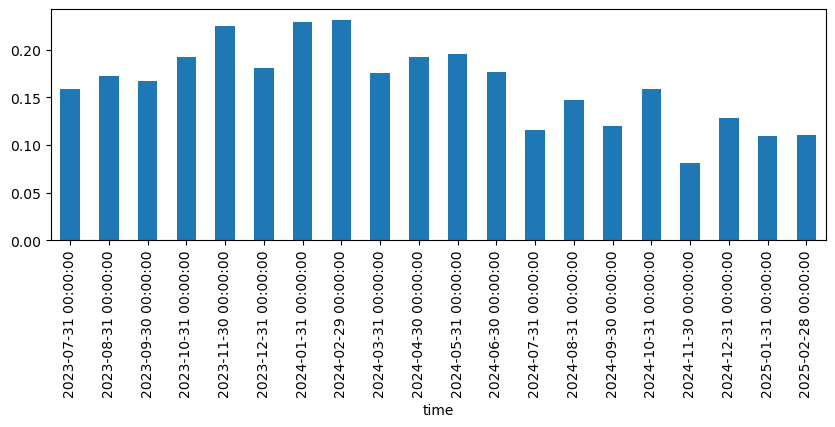

In [1114]:
mask_data = df['y_pred'].notnull()
plt.figure(figsize=(10, 3))
(df.loc[mask_data, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:
                                                                            roc_auc_score(x['target'], x['y_pred'])
                                                                                                          ) - 0.5).plot.bar()

#### 2. WIN

In [1118]:
np.quantile(df.loc[mask_valid, 'y_pred'], q=q)

0.22686240875366323

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_93253/3700073749.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:


<Axes: xlabel='time'>

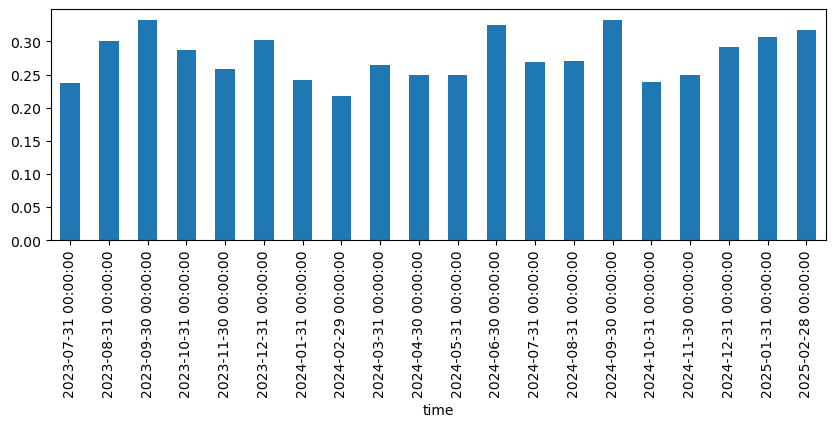

In [1120]:
q = 0.995
col_target = 'target'

mask_last_bin = df['y_pred'] >= np.quantile(df.loc[mask_valid, 'y_pred'], q=q)

mask_data = df['y_pred'].notnull()
plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:
                                                                            x[col_target].mean()).plot.bar()

#### 3. income_rate

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_93253/2532690047.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:


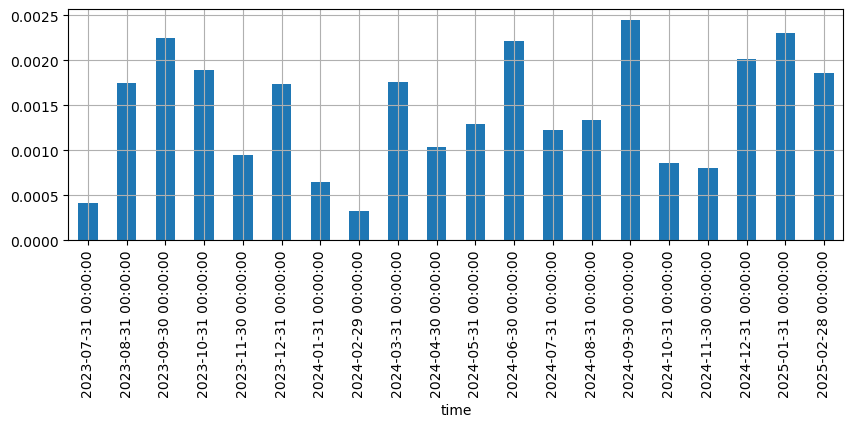

In [1122]:
q = 0.995
col_target = 'income_rate'

mask_last_bin = df['y_pred'] >= np.quantile(df.loc[mask_valid, 'y_pred'], q=q)

mask_data = df['y_pred'].notnull()
plt.figure(figsize=(10, 3))
(df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:
                                                                            x[col_target].mean()) -1).plot.bar()
plt.grid()

#### 4. Отложенная выборка

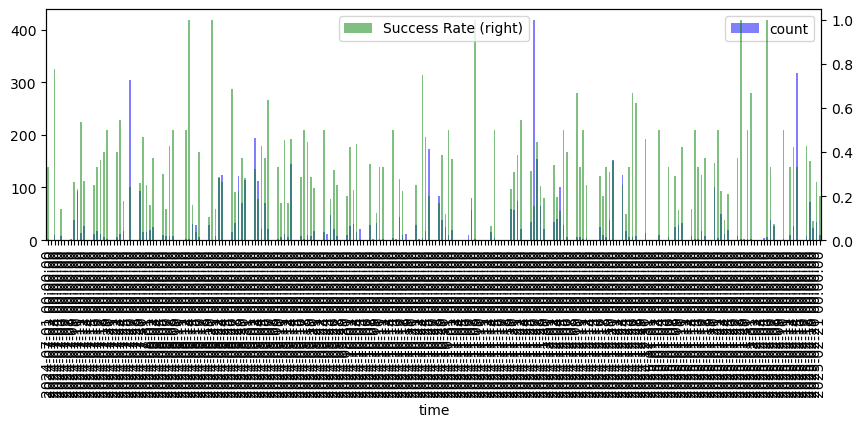

INCOME_RATE


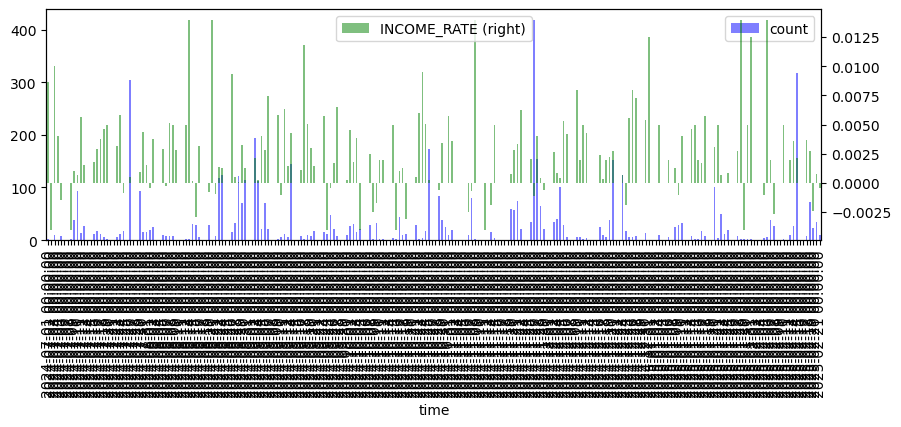

In [1124]:
#distibution in time
#win
col_pred = 'y_pred'
q = 0.995
freq='D'

mask_data = mask_valid|mask_test|mask_test2|mask_test3

threshold = np.quantile(df.loc[mask_valid, col_pred], q=q)
mask_last_bin = df[col_pred] >= threshold


plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()


#distibution in time
#income_rate
print('INCOME_RATE')

plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='INCOME_RATE')
plt.legend()
plt.show()

In [1127]:
#y_test3

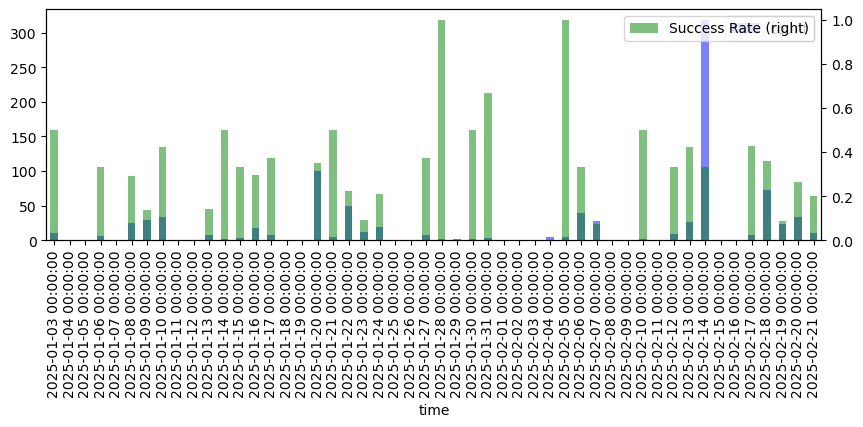

INCOME_RATE


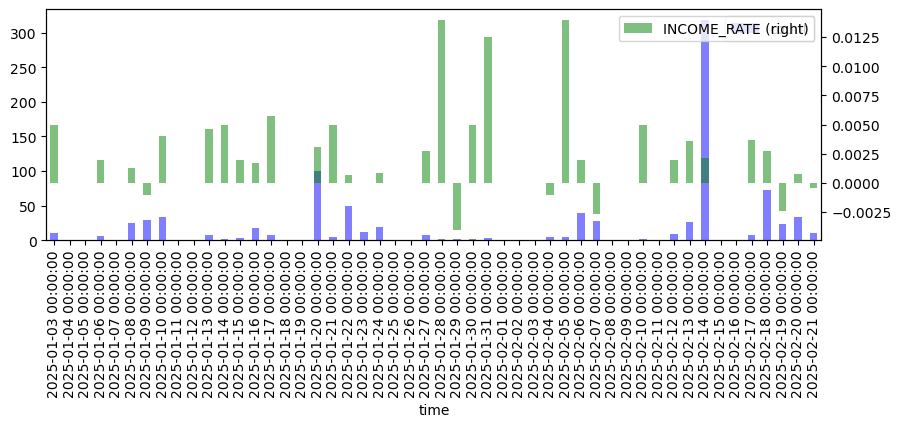

In [1129]:
#distibution in time
#win
col_pred = 'y_pred'
q = 0.995
freq='D'


mask_data = mask_test3


threshold = np.quantile(df.loc[mask_valid, col_pred], q=q)
mask_last_bin = df[col_pred] >= threshold


plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()


#distibution in time
#income_rate
print('INCOME_RATE')

plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='INCOME_RATE')
plt.legend()
plt.show()

In [1132]:
#mean_income_rate_by_day
(df.loc[mask_valid&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean(), (df.loc[mask_test&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean(), (df.loc[mask_test2&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean()


(0.002809236145604034, 0.0023645536005738143, 0.0030097958228476546)

In [1134]:
df.loc[mask_valid&mask_last_bin, 'time'].dt.date.nunique(), df.loc[mask_test&mask_last_bin, 'time'].dt.date.nunique(),  df.loc[mask_test2&mask_last_bin, 'time'].dt.date.nunique()


(44, 44, 37)

In [1136]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.995)

In [1138]:
#sum_income_rate
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.06049424306550394, 0.049778267425649315, 0.05359498661153247)

In [1141]:
#test3
(df.loc[mask_test3&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean()

0.0030187571083587226

In [1143]:
df.loc[mask_test3&mask_last_bin, 'time'].dt.date.nunique()

33

In [1145]:
mean_income_rate_month(D_test3, y_pred_test3, threshold=threshold)

0.055606090705674446

In [1149]:
mask_data = mask_valid | mask_test | mask_test2

In [1151]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()


/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_93253/1640586492.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_data&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.0006639938354492188

In [1154]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_valid&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_93253/1656526771.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_valid&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.0007162486965006048

In [1156]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_test&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_93253/192763211.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_test&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.0007945664904334328

In [1158]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_test2&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_93253/1559495362.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_test2&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.0004465773298933699

In [1160]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_test3&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_93253/2683039865.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_test3&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.0012062589327494304

#### Points in life

In [1164]:
threshold

0.22686240875366323

In [ ]:
mask_dev = df['time'] > pd.Timestamp('2025-01-20')
df.loc[mask_dev, 'y_pred'] = model.predict(df.loc[mask_dev, features_fe]) #feratures_fe

#threshold = 0.5695387939626755
df.loc[mask_dev, ['time', 'y_pred']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: (x['y_pred'] >= threshold).sum())

### Обучить на всем

In [1337]:
features

['close_w30_lvl_1.015-1.02',
 'close_w30_lvl_1.02-1.03',
 'close_w120_lvl_1.02-1.03',
 'close/close_w5_expma',
 'close/close_w10_expma',
 'close/close_w20_expma',
 'close/close_w30_expma',
 'close/close_w60_expma',
 'close/close_w120_expma',
 'close_w5_expma/close_w20_expma',
 'close_w5_expma/close_w30_expma',
 'close_w5_expma/close_w60_expma',
 'close_w5_expma/close_w120_expma',
 'close_w10_expma/close_w30_expma',
 'close_w10_expma/close_w60_expma',
 'close_w10_expma/close_w120_expma',
 'close_w20_expma/close_w60_expma',
 'close_w20_expma/close_w120_expma',
 'close_w30_expma/close_w60_expma',
 'close_w30_expma/close_w120_expma']

In [1339]:
features_fe = features
cat_features = []
target = 'target'

In [1341]:
mask_data = mask_train | mask_valid | mask_test | mask_test2
#mask_data = (pd.Timestamp('2024-01-01') <= df['time']) &  (df['time'] < pd.Timestamp('2025-01-01'))
#print(mask_data.sum())
#mask_data = mask_valid | mask_test | mask_test2
#mask_data = mask_test2

D_data = lgbm.Dataset(df.loc[mask_data, features_fe], label=df.loc[mask_data, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)


D_data.income_rate = df.loc[mask_data, 'income_rate'].values

D_data.time = df.loc[mask_data, 'time'].values

In [1343]:
D_test3 = lgbm.Dataset(df.loc[mask_test3, features_fe], label=df.loc[mask_test3, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
D_test3.time = df.loc[mask_test3, 'time'].values

In [1367]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    
    
    "num_boost_round" : 100,

    
    "num_leaves": 31,
    #"learning_rate": 0.001,
     "feature_fraction": 0.5,
     "bagging_fraction": 0.5,
     "bagging_freq": 1,
     'lambda_l1' : 1,
     'lambda_l2' : 1,
    #"verbose": 0,

    #'max_bin' : 100000,
    
    
    # "metric": "auc",
      "metric" : 'mean_income_rate',
     "early_stopping" : 10,



    
}

In [1369]:
#model.num_trees()

In [1371]:
#del params['metric'], params['early_stopping']

In [1373]:
#params['num_boost_round'] = 40

In [1375]:
model = lgbm.train(params, train_set=D_data, valid_sets=[D_test3], feval=mean_income_rate)

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	valid_0's mean_income_rate: 0.00141


In [1377]:
model.num_trees()

13

In [1352]:
#dump_pkl(model, 'model_-0.5_+1.5_4hour.pkl')

In [1354]:
#model = load_pkl('model_-0.5_+1.5_4hour.pkl')
#model.num_trees()

In [1379]:
y_pred_data= model.predict(D_data.data)


df["y_pred"] = None
df.loc[mask_data, 'y_pred'] = y_pred_data

roc_auc_score(D_data.label, y_pred_data)

0.6770638965364955

In [1382]:
y_pred_test3 = model.predict(D_test3.data)
df.loc[mask_test3, 'y_pred'] = y_pred_test3
roc_auc_score(D_test3.label, y_pred_test3)

0.6090700984894337

In [1386]:
THREHOLD = np.quantile(y_pred_test3, q=0.995)
#THRESHOLD = threshold
THRESHOLD

0.22686240875366323

In [1388]:
mean_income_rate_point(D_data, y_pred_data, threshold=THRESHOLD)

0.0026379170347794467

In [1391]:
mean_income_rate_day(D_data, y_pred_data, threshold=THRESHOLD)

0.0036637617789679307

In [1394]:
mean_income_rate_month(D_data, y_pred_data, threshold=THRESHOLD)

0.05208178282717489

In [1398]:
mean_income_rate_point(D_test3, y_pred_test3, threshold=THRESHOLD)

0.0026117390072024627

In [1400]:
mean_income_rate_tick(D_test3, y_pred_test3, threshold=THRESHOLD)

0.0026933455751055775

In [1402]:
mean_income_rate_day(D_test3, y_pred_test3, threshold=THRESHOLD)

0.004326890513360705

In [1404]:
mean_income_rate_month(D_test3, y_pred_test3, threshold=THRESHOLD)

0.05260587939928016

In [ ]:
# Стало лучше, но тут я обучался под valid

In [1221]:
# +-

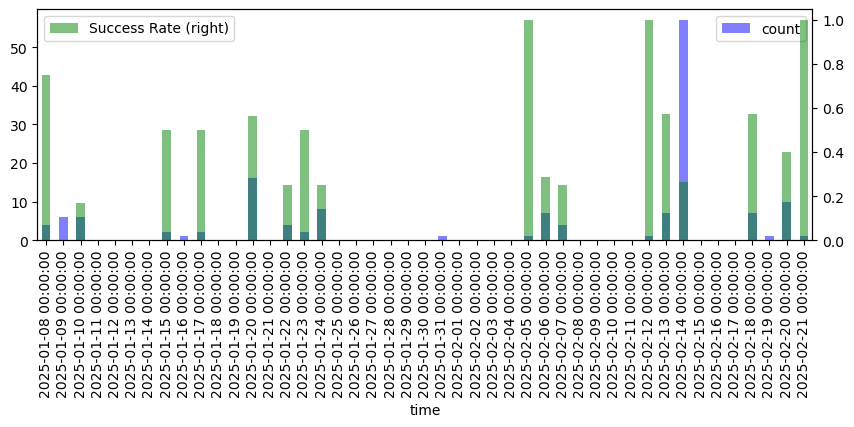

INCOME_RATE


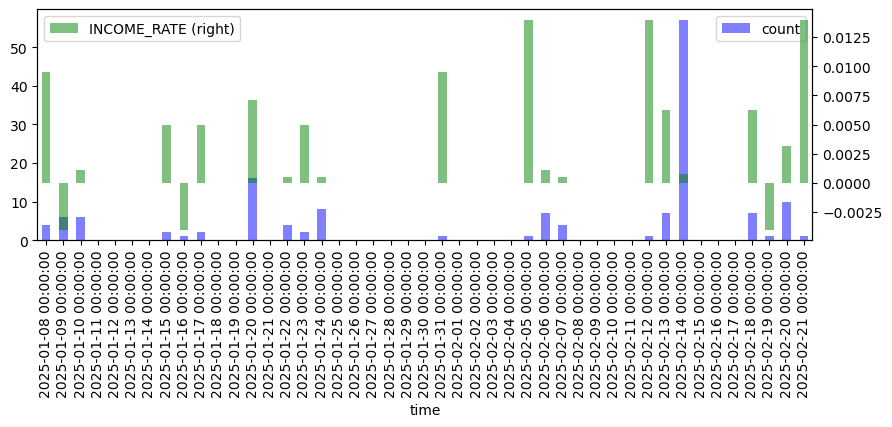

In [1406]:
#distibution in time
#win
col_pred = 'y_pred'
freq='D'


mask_data = mask_test3


#threshold = np.quantile(df.loc[mask_valid, col_pred], q=q)
mask_last_bin = df[col_pred] > THRESHOLD


plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()


#distibution in time
#income_rate
print('INCOME_RATE')

plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='INCOME_RATE')
plt.legend()
plt.show()

In [1411]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features_fe, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: -x[1])

[('close_w20_expma/close_w120_expma', 18.4),
 ('close_w120_lvl_1.02-1.03', 16.46),
 ('close_w30_expma/close_w120_expma', 13.64),
 ('close/close_w5_expma', 8.8),
 ('close_w10_expma/close_w120_expma', 7.4),
 ('close/close_w10_expma', 5.55),
 ('close_w30_expma/close_w60_expma', 4.48),
 ('close_w5_expma/close_w120_expma', 3.96),
 ('close_w10_expma/close_w30_expma', 3.36),
 ('close/close_w30_expma', 2.44),
 ('close_w20_expma/close_w60_expma', 2.33),
 ('close/close_w120_expma', 2.16),
 ('close_w5_expma/close_w30_expma', 2.16),
 ('close_w10_expma/close_w60_expma', 2.1),
 ('close_w5_expma/close_w20_expma', 1.76),
 ('close_w5_expma/close_w60_expma', 1.74),
 ('close/close_w60_expma', 1.48),
 ('close_w30_lvl_1.015-1.02', 0.83),
 ('close/close_w20_expma', 0.8),
 ('close_w30_lvl_1.02-1.03', 0.12)]